# Data Science for Good with PASSNYC

## Introduction

Each year, thousands of eighth and ninth grade students in New York City take the Specialized High Schools Admissions Test (SHSAT) in hopes of getting into one of the city's eight specialized high schools. These institutions are considered to be prestigious and can have potentially tremendous impacts on students' lives, but the only way to gain admission is to take the SHSAT.

Recently, the demographics at the specialized high schools have become increasingly homogeneous, so the mission of PASSNYC is to identify schools with underrepresented demographics and, through consultation and outreach, increase the amount of students from these schools that take the SHSAT. Ultimately, if more diverse students take the exam, then more of them will also be admitted.

As PASSNYC states in its competition on [Kaggle](https://www.kaggle.com/passnyc/data-science-for-good), the organization would like more assistance in identifying schools where its services would be most useful. Therefore, I will perform some wrangling and exploration on data provided by both PASSNYC and other public sources, as well as construct a model to learn more about what features are important in identifying schools with low participation in the SHSAT. I will also evaluate how useful this model is by looking at the actual vs. predicted values and the distribution of residuals. This will allow me to see how well the model actually fits the existing data and, consequently, how much I can trust the feature importance provided by the model.

## Data Wrangling & Exploration

To begin, I will import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from datetime import datetime, date, time
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# remove any warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### School Explorer Data

The first dataset I will read in is the School Explorer data provided by PASSNYC.

Here are the column definitions according to [Kaggle](https://www.kaggle.com/passnyc/data-science-for-good?select=2016+School+Explorer.csv):
- `sed_code`: State Education Department
- `grades`: The range of grade levels in this school
- `grade_low`: Lowest grade level in this school
- `grade_high`: Highest grade level in this school
- `economic_need_index`: (%temp housing) + (% HRA eligible \*0.5) + (% free lunch eligible \*0.5). The higher the index, the higher the need
- `percent_ell`: ELL = English Language Learners
- `student_attendance_rate`: total number of days attended by all students / total number of days on register for all students
- `percent_of_students_chronically_absent`: Missing 10% of school days - or 18 days+ per year in a 180-day school year
- `rigorous_instruction_percent` and `rigorous_instruction_rating`: How well the curriculum and instruction engage students, build critical-thinking skills, and are aligned to the Common
- `collaborative_teachers_percent` and `collaborative_teachers_rating`: How well teachers participate in opportunities to develop, grow, and contribute to the continuous
- `supportive_environment_percent` and `supportive_environment_rating`: How well the school establishes a culture where students feel safe, challenged to grow, and supported to meet high
- `effective_school_leadership_percent` and `effective_school_leadership_rating`: How well school leadership inspires the school community with a clear instructional vision and effectively distributes
- `strong_family_community_ties_percent` and `strong_family_community_ties_rating`: How well the school forms effective partnerships with families to improve the school
- `trust_percent` and `trust_rating`: Whether the relationships between administrators, educators, students, and families are based on trust and respect
- `student_achievement_rating`: Weighted Average Score + the Closing the Achievement Gap Additional Points - 4: Exceeding Target, 3:
- `average_ela_proficiency`: ELA = English Language Arts Performance Levels = 1 (insufficient), 2 (partial but insufficient), 3 (sufficient), and 4 (more

In [2]:
schools = pd.read_csv('2016 School Explorer.csv')
schools.head()

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency,Grade 3 ELA - All Students Tested,Grade 3 ELA 4s - All Students,Grade 3 ELA 4s - American Indian or Alaska Native,Grade 3 ELA 4s - Black or African American,Grade 3 ELA 4s - Hispanic or Latino,Grade 3 ELA 4s - Asian or Pacific Islander,Grade 3 ELA 4s - White,Grade 3 ELA 4s - Multiracial,Grade 3 ELA 4s - Limited English Proficient,Grade 3 ELA 4s - Economically Disadvantaged,Grade 3 Math - All Students tested,Grade 3 Math 4s - All Students,Grade 3 Math 4s - American Indian or Alaska Native,Grade 3 Math 4s - Black or African American,Grade 3 Math 4s - Hispanic or Latino,Grade 3 Math 4s - Asian or Pacific Islander,Grade 3 Math 4s - White,Grade 3 Math 4s - Multiracial,Grade 3 Math 4s - Limited English Proficient,Grade 3 Math 4s - Economically Disadvantaged,Grade 4 ELA - All Students Tested,Grade 4 ELA 4s - All Students,Grade 4 ELA 4s - American Indian or Alaska Native,Grade 4 ELA 4s - Black or African American,Grade 4 ELA 4s - Hispanic or Latino,Grade 4 ELA 4s - Asian or Pacific Islander,Grade 4 ELA 4s - White,Grade 4 ELA 4s - Multiracial,Grade 4 ELA 4s - Limited English Proficient,Grade 4 ELA 4s - Economically Disadvantaged,Grade 4 Math - All Students Tested,Grade 4 Math 4s - All Students,Grade 4 Math 4s - American Indian or Alaska Native,Grade 4 Math 4s - Black or African American,Grade 4 Math 4s - Hispanic or Latino,Grade 4 Math 4s - Asian or Pacific Islander,Grade 4 Math 4s - White,Grade 4 Math 4s - Multiracial,Grade 4 Math 4s - Limited English Proficient,Grade 4 Math 4s - Economically Disadvantaged,Grade 5 ELA - All Students Tested,Grade 5 ELA 4s - All Students,Grade 5 ELA 4s - American Indian or Alaska Native,Grade 5 ELA 4s - Black or African American,Grade 5 ELA 4s - Hispanic or Latino,Grade 5 ELA 4s - Asian or Pacific Islander,Grade 5 ELA 4s - White,Grade 5 ELA 4s - Multiracial,Grade 5 ELA 4s - Limited English Proficient,Grade 5 ELA 4s - Economically Disadvantaged,Grade 5 Math - All Students Tested,Grade 5 Math 4s - All Students,Grade 5 Math 4s - American Indian or Alaska Native,Grade 5 Math 4s - Black or African American,Grade 5 Math 4s - Hispanic or Latino,Grade 5 Math 4s - Asian or Pacific Islander,Grade 5 Math 4s - White,Grade 5 Math 4s - Multiracial,Grade 5 Math 4s - Limited English Proficient,Grade 5 Math 4s - Economically Disadvantaged,Grade 6 ELA - All Students Tested,Grade 6 ELA 4s - All Students,Grade 6 ELA 4s - American Indian or Alaska Native,Grade 6 ELA 4s - Black or African American,Grade 6 ELA 4s - Hispanic or Latino,Grade 6 ELA 4s - Asian or Pacific Islander,Grade 6 ELA 4s - White,Grade 6 ELA 4s - Multiracial,Grade 6 ELA 4s - Limited English Proficient,Grade 6 ELA 4s - Economically Disadvantaged,Grade 6 Math - All Students Tested,Grade 6 Math 4s - All Students,Grade 6 Math 4s - American Indian or Alaska Native,Grade 6 Math 4s - Black or African American,Grade 6 Math 4s - Hispanic or Latino,Grade 6 Math 4s - Asian or Pacific Islander,Grade 6 Math 4s - White,Grade 6 Math 4s - Multiracial,Grade 6 Math 4s - Limited English Proficient,Grade 6 Math 4s - Economically Disadvantaged,Grade 7 ELA - All Students Tested,Grade 7 ELA 4s - All Students,Grade 7 ELA 4s - American Indian or Alaska Native,Grade 7 ELA 4s - Black or African American,Grade 7 ELA 4s - His

In [3]:
schools.shape

(1272, 161)

I prefer column names to be lowercase with spaces separated by `_`, so I will write a function below that converts column names.

In [4]:
def rename_col(col):
    '''
    INPUT:
    col (str) - column name
    OUTPUT:
    new_col (str) - new column name
    
    Rename columns to be all lowercase with spaces replaced by underscores.
    '''
    
    new_col = col.lower()
    new_col = new_col.replace('%', 'percent')
    new_col = re.sub(r'[^\w\s]', ' ', new_col).strip()
    new_col = re.sub(r'\s+', '_', new_col)
    
    return new_col

schools.rename(columns=lambda x: rename_col(x), inplace=True)

Now I will see how many missing values are in each column.

In [5]:
schools.isnull().sum()

adjusted_grade                                      1270
new                                                 1245
other_location_code_in_lcgms                        1271
school_name                                            0
sed_code                                               0
location_code                                          0
district                                               0
latitude                                               0
longitude                                              0
address_full                                           0
city                                                   0
zip                                                    0
grades                                                 0
grade_low                                              0
grade_high                                             0
community_school                                       0
economic_need_index                                   25
school_income_estimate         

In [6]:
# descriptive statistics for percentage of missing values in each column
schools_prop_null = schools.isnull().sum()/schools.shape[0]
schools_prop_null.describe()

count    161.000000
mean       0.024679
std        0.136586
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.999214
dtype: float64

In [7]:
(schools.isnull().sum() > 0).sum()/schools.shape[1]

0.13664596273291926

It looks like the majority of columns in the `schools` dataframe do not have any missing values. The average percentage of missing values is 2.5%, and only 13.7% of columns actually have any missing values.

Considering that the `schools` dataframe has 1,272 rows, the `adjusted_grade` and `other_location_code_in_lcgms` do not look particularly useful, so I will drop those. I will also drop `sed_code`, as each school can be identified by its `location_code`, and `address_full` because I am just interested in the general area where a school is located, rather than the specific address.

In [8]:
drop_cols = [
    'adjusted_grade',
    'other_location_code_in_lcgms',
    'sed_code',
    'address_full'
]

schools.drop(drop_cols, axis=1, inplace=True)

I will also take a look at each column's data type to see if any need to be changed.

In [9]:
schools.dtypes

new                                                  object
school_name                                          object
location_code                                        object
district                                              int64
latitude                                            float64
longitude                                           float64
city                                                 object
zip                                                   int64
grades                                               object
grade_low                                            object
grade_high                                           object
community_school                                     object
economic_need_index                                 float64
school_income_estimate                               object
percent_ell                                          object
percent_asian                                        object
percent_black                           

It seems like the `new` and `community_school` columns should possibly be boolean, but I will print out the unique values just to be certain.

In [10]:
schools['new'].unique()

array([nan, 'x'], dtype=object)

In [11]:
schools['community_school'].unique()

array(['Yes', 'No'], dtype=object)

These columns indeed appear to be boolean based on the two unique values for each, so I will convert them.

In [12]:
schools['new'] = schools['new'] == 'x'
schools['community_school'] = schools['community_school'] == 'Yes'

The values in the column `school_income_estimate` were also read in as strings, so I will convert those by removing any `$` or `,` symbols.

In [13]:
schools['school_income_estimate'] = schools['school_income_estimate'].str.strip()
schools['school_income_estimate'] = schools['school_income_estimate'].str.replace('$', '')
schools['school_income_estimate'] = schools['school_income_estimate'].str.replace(',', '')
schools['school_income_estimate'] = schools['school_income_estimate'].astype(float)

There are also several columns that have read in percentages as strings due to the `%` symbol. I will write a function to make the conversion of these columns more efficient.

In [14]:
def convert_percent_str(str_col):
    '''
    INPUT:
    str_col (Series) - Pandas Series containing strings with '%' at the end
    OUTPUT:
    percent_col (float) - proportion equal to the input percentage
    
    Convert any columns that have read in percentages as strings to floats.
    '''
    
    percent_col = str_col.str.replace('%', '').astype(float)
    percent_col /= 100
    
    return percent_col

# create a list with all columns that have percentages read in as strings
percent_cols = ['student_attendance_rate']
# check for columns that begin or end with 'percent'
starts_with_percent = list(schools.columns[[col.startswith('percent') for col in schools.columns]])
ends_with_percent = list(schools.columns[[col.endswith('percent') for col in schools.columns]])
percent_cols += starts_with_percent
percent_cols += ends_with_percent

for col in percent_cols:
    schools[col] = convert_percent_str(schools[col])

I am also curious to see if there are any duplicate schools in the dataset.

In [15]:
schools.duplicated(subset='location_code').sum()

0

In [16]:
schools.duplicated(subset='school_name').sum()

2

Interestingly, there are no duplicate schools based on the `location_code`, which should be the unique identifier, but there are duplicates in `school_name`. That seems a little weird, so I will investigate a little.

In [17]:
schools[schools.duplicated(subset='school_name', keep=False)]

,new,school_name,location_code,district,latitude,longitude,city,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_

After doing some research on Google, it turns out that these schools are all valid and not duplicates of each other. But this is still good information to know, as I will rely more on `location_code` going forward.

I will also take a look at the descriptive statistics just to make sure they look reasonable.

In [18]:
schools.describe()

,district,latitude,longitude,zip,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,collaborative_teachers_percent,supportive_environment_percent,effective_school_leadership_percent,strong_family_community_ties_percent,trust_percent,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_students_tested,grade_7_math_4s_all_students,grade_7_math_4s_american_indian_or_alaska_native,grade_7_math_4s_black_or_african_american,grade_7_math_4s_hispanic_or_latino,grade_7_math_4s_asian_or_pacific_islander,grade_7_math_4s_white,grade_7_math_4s_multiracial,grade_7_math_4s_

The descriptive statistics look fine, but I may uncover something later when performing some exploratory data visualization.

I have performed the necessary data wrangling on the `schools` dataset for now. I will show the dataframe head and column data types to make sure that my changes were made correctly.

In [19]:
schools.head()

,new,school_name,location_code,district,latitude,longitude,city,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_

In [20]:
schools.dtypes

new                                                    bool
school_name                                          object
location_code                                        object
district                                              int64
latitude                                            float64
longitude                                           float64
city                                                 object
zip                                                   int64
grades                                               object
grade_low                                            object
grade_high                                           object
community_school                                       bool
economic_need_index                                 float64
school_income_estimate                              float64
percent_ell                                         float64
percent_asian                                       float64
percent_black                           

Now I will create some visualizations to explore the `schools` data further. First I want to see how many schools there are in each district.

In [21]:
base_color = sb.color_palette()[0]

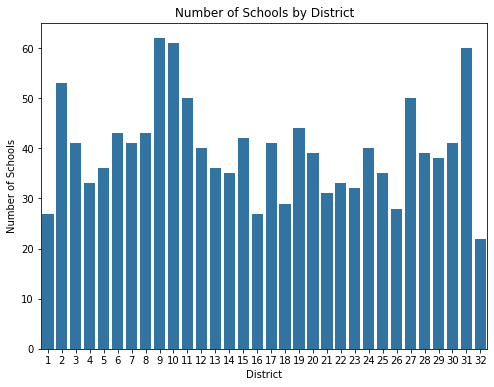

In [22]:
plt.figure(figsize=[8, 6])
sb.countplot(data=schools, x='district', color=base_color)
plt.title('Number of Schools by District')
plt.xlabel('District')
plt.ylabel('Number of Schools');

I was expecting each district to have roughly the same number of schools, but it does not seem like that is the case. There is also no clear pattern to how many schools are in each district. District 9 has the most schools, while District 32 has the fewest.

I would also like to see the demographics for each district.

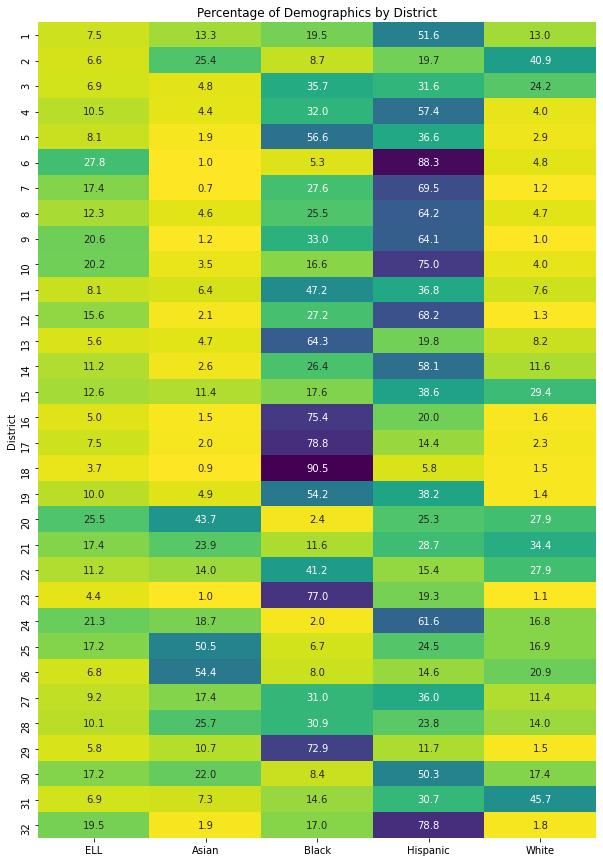

In [23]:
# calculate the average of each demographic by district
demographic_cols = ['percent_ell', 'percent_asian', 'percent_black', 'percent_hispanic', 'percent_white']
demo_by_district = schools.groupby(['district'])[demographic_cols].mean()*100
# format column names for the visualizations
demo_by_district.rename(columns=lambda x: x[len('percent_'):], inplace=True)
demo_by_district.rename(columns=lambda x: x.capitalize() if x != 'ell' else x.upper(), inplace=True)

plt.figure(figsize=[10, 15])
sb.heatmap(demo_by_district, annot=True, fmt='.1f', cmap='viridis_r', cbar=False)
plt.title('Percentage of Demographics by District')
plt.ylabel('District');

It seems like the Black and Hispanic populations tend to be more clustered in certain districts, whereas the other demographics are less concentrated. In addition, the Black and Hispanic demographics seem to be connected, given that several districts appear to have high combinations of both populations.

Now I want to look at the distribution of the various benchmarks that schools are measured by, which include Rigorous Instruction, Collaborative Teachers, Supportive Environment, Effective School Leadership, Strong Family Community Ties, and Trust.

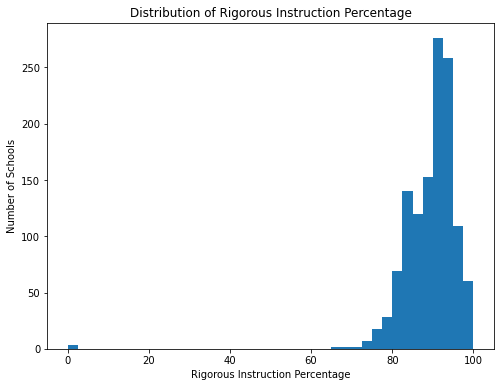

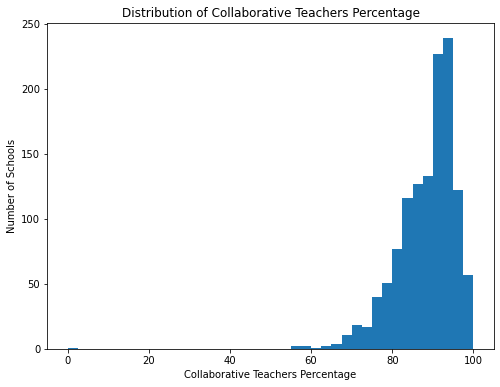

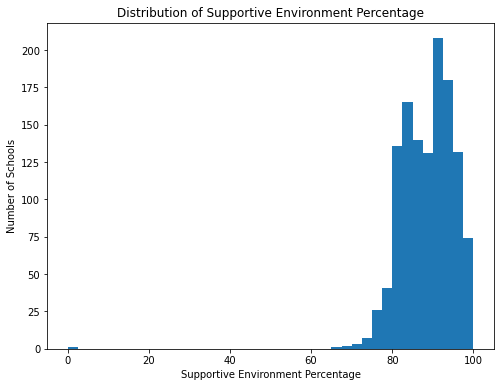

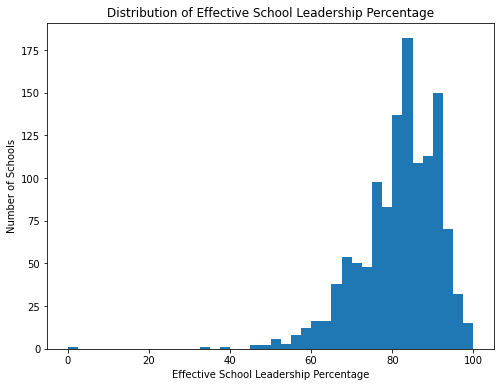

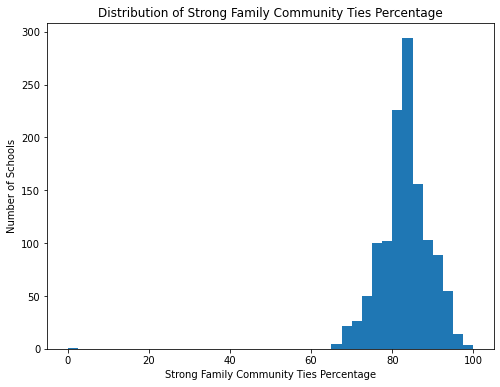

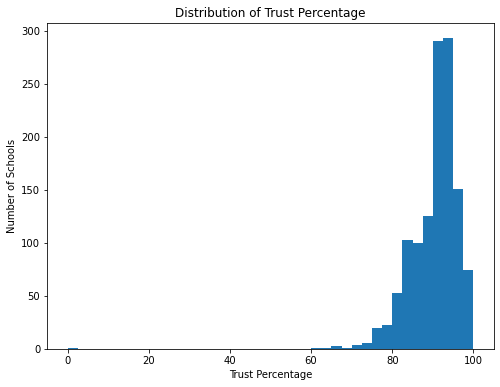

In [24]:
def plot_benchmark_attainment(df, var, bin_size, benchmark):
    '''
    INPUT:
    df (DataFrame) - dataframe containing the variable of interest
    var (str) - numeric variable to plot
    bin_size (float) - histogram bin size
    benchmark (str) - name of the variable
    
    OUTPUT:
    None
    
    Plot a histogram for the distribution of a benchmark score.
    '''
    
    plt.figure(figsize=[8, 6])
    xticks = np.arange(0, 1.2, 0.2)
    xtick_labels = np.arange(0, 120, 20)
    bins = np.arange(df[var].min(), df[var].max()+bin_size, bin_size)
    plt.hist(data=df, x=var, bins=bins)
    plt.title('Distribution of '+benchmark+' Percentage')
    plt.xlabel(benchmark+' Percentage')
    plt.ylabel('Number of Schools')
    plt.xticks(xticks, xtick_labels);
    
benchmarks = [
    'Rigorous Instruction',
    'Collaborative Teachers',
    'Supportive Environment',
    'Effective School Leadership',
    'Strong Family Community Ties',
    'Trust'
]

for benchmark in benchmarks:
    var = benchmark.lower().replace(' ', '_')+'_percent'
    plot_benchmark_attainment(schools, var, 0.025, benchmark)

Most of these benchmarks appear to be left skewed and actually have peaks around 90%. Only Effective School Leadership and Strong Family Community Ties are more normally distributed with peaks around 80%. One thing that also stands out to me is that there seems to be a few schools that have 0% for each benchmark. I will do some investigating to see what schools these are.

In [25]:
for benchmark in benchmarks:
    var = benchmark.lower().replace(' ', '_')+'_percent'
    benchmark_min = schools[schools[var] == schools[var].min()]
    print(benchmark_min[['location_code', var]])

     location_code  rigorous_instruction_percent
89          03M241                           0.0
752         23K150                           0.0
1183        84M202                           0.0
     location_code  collaborative_teachers_percent
1183        84M202                             0.0
     location_code  supportive_environment_percent
1183        84M202                             0.0
     location_code  effective_school_leadership_percent
1183        84M202                                  0.0
     location_code  strong_family_community_ties_percent
1183        84M202                                   0.0
     location_code  trust_percent
1183        84M202            0.0


It looks like the school with the `location_code` 84M202 has a score of 0% for each benchmark, and only Rigorous Instruction has a score of 0% for three different schools. I think these might be errors, so I will remove them from the dataset.

In [26]:
schools = schools.query('rigorous_instruction_percent > 0')

Now I want to see the distributions of `economic_need_index` and `school_income_estimate`.

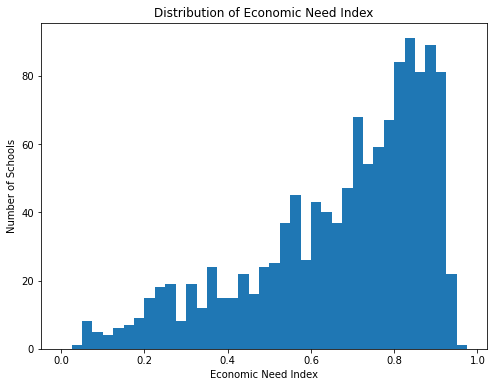

In [27]:
bin_size = 0.025
bins = np.arange(0, schools['economic_need_index'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(data=schools, x='economic_need_index', bins=bins)
plt.title('Distribution of Economic Need Index')
plt.xlabel('Economic Need Index')
plt.ylabel('Number of Schools');

The distribution of `economic_need_index` is left-skewed, meaning that more schools have high economic need.

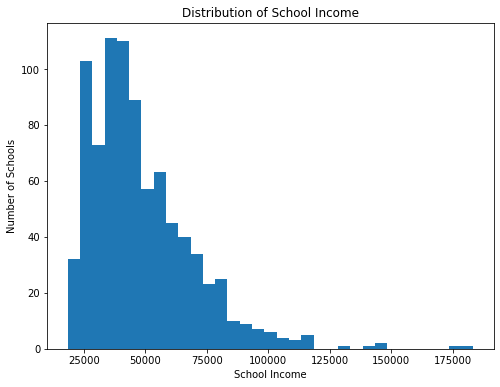

In [28]:
bin_size = 5000
bins = np.arange(schools['school_income_estimate'].min(), schools['school_income_estimate'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(data=schools, x='school_income_estimate', bins=bins)
plt.title('Distribution of School Income')
plt.xlabel('School Income')
plt.ylabel('Number of Schools');

The distribution of `school_income_estimate` is right-skewed, meaning that most schools have lower income. This makes sense given that many schools also have high economic need.

There seems to be a small group of schools that have an income of higher than $125,000, so I will take a look at those.

In [29]:
schools.query('school_income_estimate > 125000')

,new,school_name,location_code,district,latitude,longitude,city,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_

Nothing here looks concerning -- interestingly, these schools seem close to each other based on the `city`, `latitude`/`longitude`, and `zip`, so maybe these schools are in an affluent part of the city.

I will now take a look at the distributions of `average_ela_proficiency` and `average_math_proficiency`.

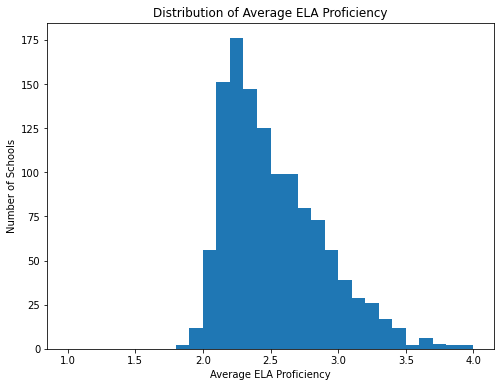

In [30]:
bin_size = 0.1
bins = np.arange(1, schools['average_ela_proficiency'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(data=schools, x='average_ela_proficiency', bins=bins)
plt.title('Distribution of Average ELA Proficiency')
plt.xlabel('Average ELA Proficiency')
plt.ylabel('Number of Schools');

The distribution of `average_ela_proficiency` is right-skewed, with the peak coming around a score of 2.3.

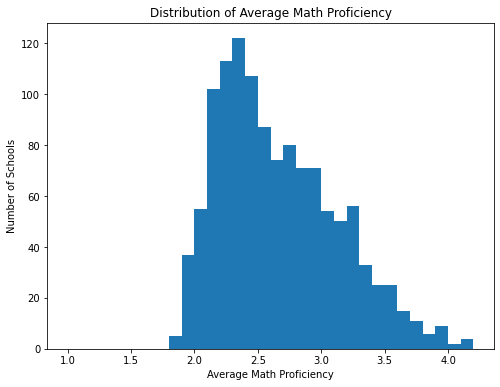

In [31]:
bin_size = 0.1
bins = np.arange(1, schools['average_math_proficiency'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(data=schools, x='average_math_proficiency', bins=bins)
plt.title('Distribution of Average Math Proficiency')
plt.xlabel('Average Math Proficiency')
plt.ylabel('Number of Schools');

Just like `average_ela_proficiency`, the distribution of `average_math_proficiency` is right-skewed with a peak around 2.3.

Now I will look at the distribution of `student_attendance_rate`.

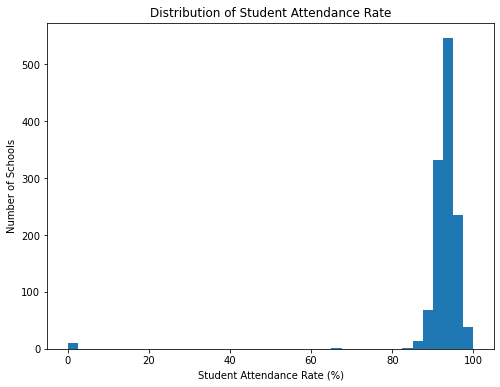

In [32]:
bin_size = 0.025
bins = np.arange(0, schools['student_attendance_rate'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
xticks = np.arange(0, 1.2, 0.2)
xtick_labels = np.arange(0, 120, 20)
plt.hist(data=schools, x='student_attendance_rate', bins=bins)
plt.title('Distribution of Student Attendance Rate')
plt.xlabel('Student Attendance Rate (%)')
plt.ylabel('Number of Schools')
plt.xticks(xticks, xtick_labels);

Just like the school quality benchmarks, there seem to be a few schools with an attendance rate of 0%. I will take a look at these.

In [33]:
schools[schools['student_attendance_rate'] == schools['student_attendance_rate'].min()]

,new,school_name,location_code,district,latitude,longitude,city,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_

Interestingly, a lot of these schools seem to belong to the Success Academy Charter School group. I will see if all of the Success Academy schools have an attendance rate of 0%.

In [34]:
schools[schools['school_name'].str.startswith('SUCCESS ACADEMY CHARTER SCHOOL')]

,new,school_name,location_code,district,latitude,longitude,city,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_

Not all of the Success Academy schools have an attendance rate of 0%, but they all have either an attendance rate of 0% or 100%. I will see how common that is among all of the schools in the dataset.

In [35]:
schools.query('student_attendance_rate == 0 or student_attendance_rate == 1')

,new,school_name,location_code,district,latitude,longitude,city,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,grade_6_ela_4s_asian_or_pacific_islander,grade_6_ela_4s_white,grade_6_ela_4s_multiracial,grade_6_ela_4s_limited_english_proficient,grade_6_ela_4s_economically_disadvantaged,grade_6_math_all_students_tested,grade_6_math_4s_all_students,grade_6_math_4s_american_indian_or_alaska_native,grade_6_math_4s_black_or_african_american,grade_6_math_4s_hispanic_or_latino,grade_6_math_4s_asian_or_pacific_islander,grade_6_math_4s_white,grade_6_math_4s_multiracial,grade_6_math_4s_limited_english_proficient,grade_6_math_4s_economically_disadvantaged,grade_7_ela_all_students_tested,grade_7_ela_4s_all_students,grade_7_ela_4s_american_indian_or_alaska_native,grade_7_ela_4s_black_or_african_american,grade_7_ela_4s_hispanic_or_latino,grade_7_ela_4s_asian_or_pacific_islander,grade_7_ela_4s_white,grade_7_ela_4s_multiracial,grade_7_ela_4s_limited_english_proficient,grade_7_ela_4s_economically_disadvantaged,grade_7_math_all_

The Success Academy schools make up the majority of schools that have either 0% or 100% attendance. That seems unlikely given how rare it is for schools to have these same attendance rates, so I will remove the Success Academy schools from the datatset.

In [36]:
schools = schools[~schools['school_name'].str.startswith('SUCCESS ACADEMY CHARTER SCHOOL')]

Now I will examine the relationship between different numerical variables. To do this, I will create a function that creates scatter plots and shows the Pearson correlation coefficient between these variables.

In [37]:
def plot_scatter_stats(df, xvar, yvar, xvar_name, yvar_name):
    '''
    INPUT:
    df (DataFrame) - dataframe containing the variables of interest
    xvar (str) - numeric x-variable to plot
    yvar (str) - numeric y-variable to plot
    xvar_name (str) - name of the x-variable
    yvar_name (str) - name of the y-variable
    
    OUTPUT:
    None
    
    Create a scatter plot of two variables and show the Pearson correlation coefficient.
    '''
    
    print(xvar_name+' vs. '+yvar_name)
    df_new = df[[xvar, yvar]]
    df_new.dropna(inplace=True)
    # calculate the Pearson correlation coefficient
    corr, p = stats.pearsonr(df_new[xvar], df_new[yvar])
    print('Pearson Correlation Coefficient: {}, P-Value: {}\n'.format(corr, p))
    
    # create scatter plot
    plt.figure(figsize=[8, 6])
    sb.regplot(data=df, x=xvar, y=yvar, fit_reg=False, scatter_kws={'alpha': 0.35})
    plt.title(xvar_name+' vs. '+yvar_name)
    plt.xlabel(xvar_name)
    plt.ylabel(yvar_name)
    plt.show();

Now I will use this to show the relationship between `school_income_estimate` and `economic_need_index`.

School Income vs. Economic Need Index
Pearson Correlation Coefficient: -0.8906641222015268, P-Value: 4.03298472538926e-290



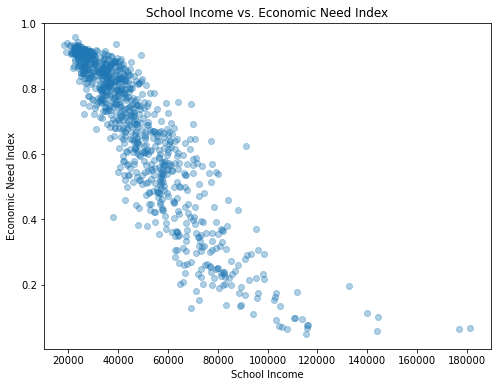

In [38]:
plot_scatter_stats(schools, 'school_income_estimate', 'economic_need_index', 'School Income', 'Economic Need Index')

As expected, there is a strong negative correlation between `school_income_estimate` and `economic_need_index`. As the income is lower, there is also more economic need. It is also important to note that most of the points are clustered in the top left corner, meaning low income and high economic need.

I will also take a look at the relationship between school income and the average subject proficiency.

School Income vs. Average ELA Proficiency
Pearson Correlation Coefficient: 0.6990410581625011, P-Value: 7.960757245361425e-121



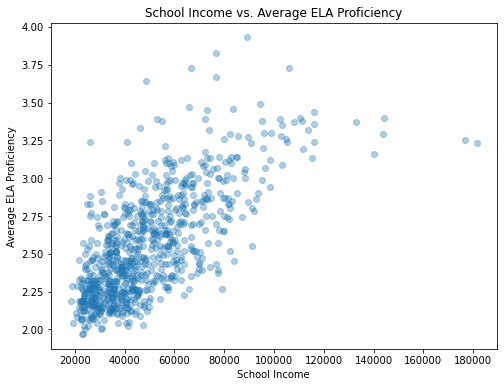

School Income vs. Average Math Proficiency
Pearson Correlation Coefficient: 0.6238977901530264, P-Value: 2.4552696948370813e-89



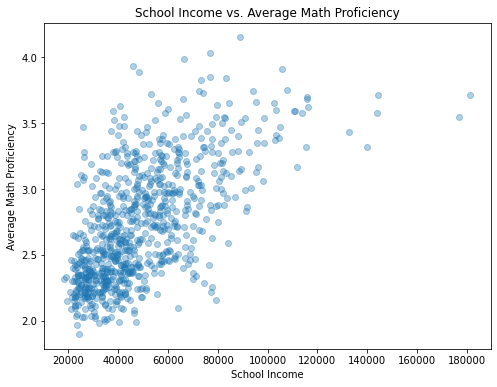

In [39]:
yvar_names = ['Average ELA Proficiency', 'Average Math Proficiency']

for yvar_name in yvar_names:
    yvar = yvar_name.lower().replace(' ', '_')
    plot_scatter_stats(schools, 'school_income_estimate', yvar, 'School Income', yvar_name)

Based on the correlation coefficients and visualizations, the relationship between economic prosperity and ELA proficiency is stronger than the relationship with math proficiency, but overall both are decently strong. As school income increases, the average ELA and math proficiencies both increase.

I also want to see the relationship between diversity and school income. I will use the percentage of white students as a representation of how diverse a school is.

Proportion of White Students vs. School Income
Pearson Correlation Coefficient: 0.7118879377172818, P-Value: 3.2245149728909536e-131



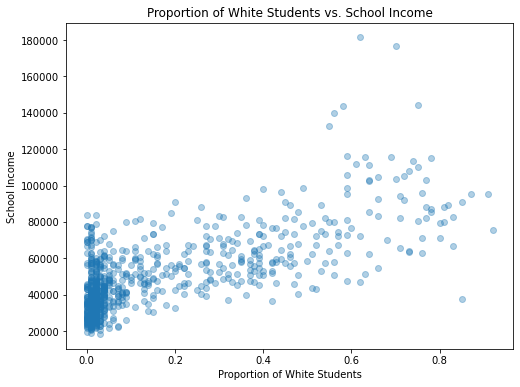

In [40]:
plot_scatter_stats(
    schools,
    'percent_white',
    'school_income_estimate',
    'Proportion of White Students',
    'School Income'
)

There is a strong positive correlation between the variables, meaning that schools with a higher proportion of white students also have a higher income. This may signal some inequality in the New York City public school system, as schools with more white students may have more funds allocated to them, though this would need further research.

I will now look the relationship between school income and the various benchmarks of school quality.

School Income vs. Rigorous Instruction
Pearson Correlation Coefficient: 0.22204359339010704, P-Value: 7.082661544851052e-11



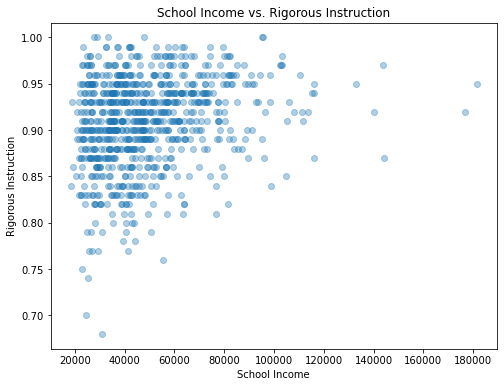

School Income vs. Collaborative Teachers
Pearson Correlation Coefficient: 0.18147673567875305, P-Value: 1.1244210466528402e-07



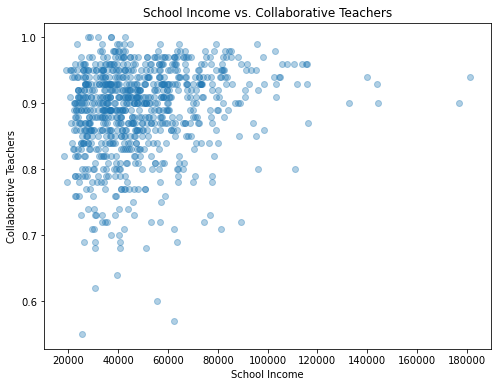

School Income vs. Supportive Environment
Pearson Correlation Coefficient: 0.31485717194425, P-Value: 7.432577161588978e-21



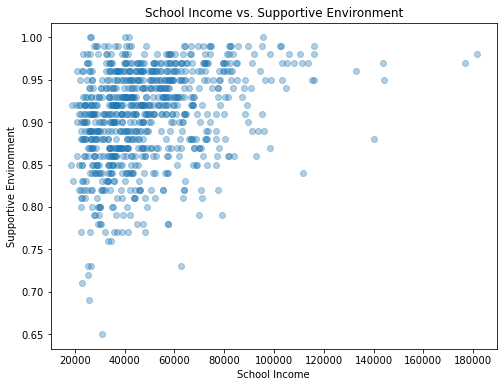

School Income vs. Effective School Leadership
Pearson Correlation Coefficient: 0.1658065089223198, P-Value: 1.2951141122710294e-06



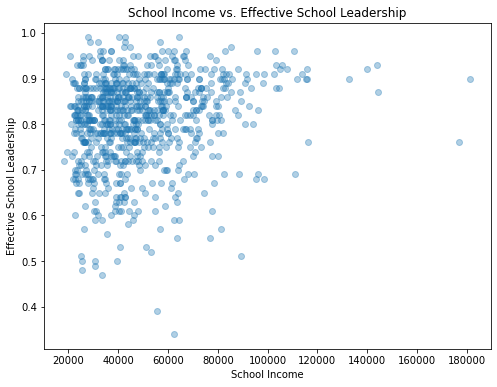

School Income vs. Strong Family Community Ties
Pearson Correlation Coefficient: 0.3328964824131688, P-Value: 2.9054460717227256e-23



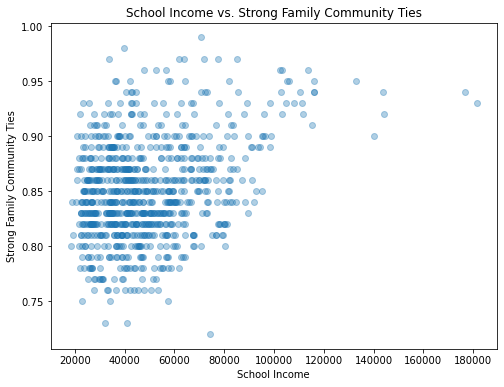

School Income vs. Trust
Pearson Correlation Coefficient: 0.13938528381709128, P-Value: 4.890268661416238e-05



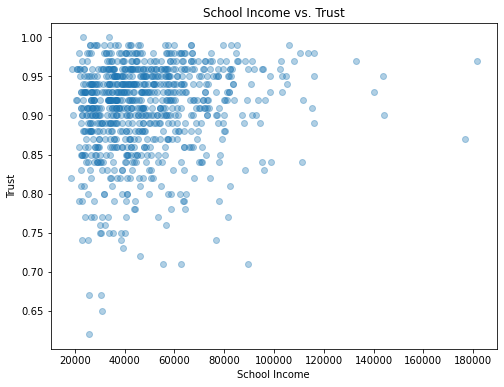

In [41]:
for benchmark in benchmarks:
    var = benchmark.lower().replace(' ', '_')+'_percent'
    plot_scatter_stats(schools, 'school_income_estimate', var, 'School Income', benchmark)

All of these are positive correlations, meaning that as school income increases, school quality also increases. However, the correlation coefficients show that these relationships are not strong. This is most likely because so many schools score highly on the quality benchmarks.

I will now look at the relationship between school income and attendance rate.

School Income vs. Student Attendance Rate
Pearson Correlation Coefficient: 0.4857132691829109, P-Value: 4.091525404381032e-51



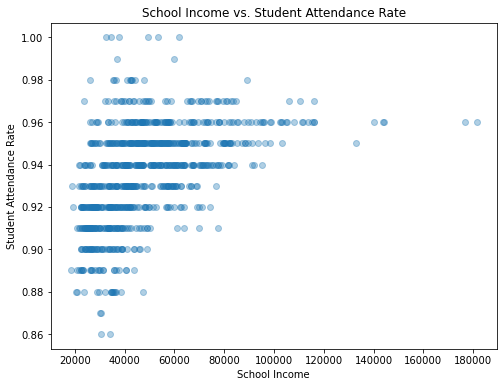

In [42]:
plot_scatter_stats(
    schools,
    'school_income_estimate',
    'student_attendance_rate',
    'School Income',
    'Student Attendance Rate'
)

There appears to be a decently strong positive correlation between the variables, meaning that as school income increases, attendance rate also increases.

I will also create a heatmap that shows the proportion of students who scored 4s by grade and district, for each subject.

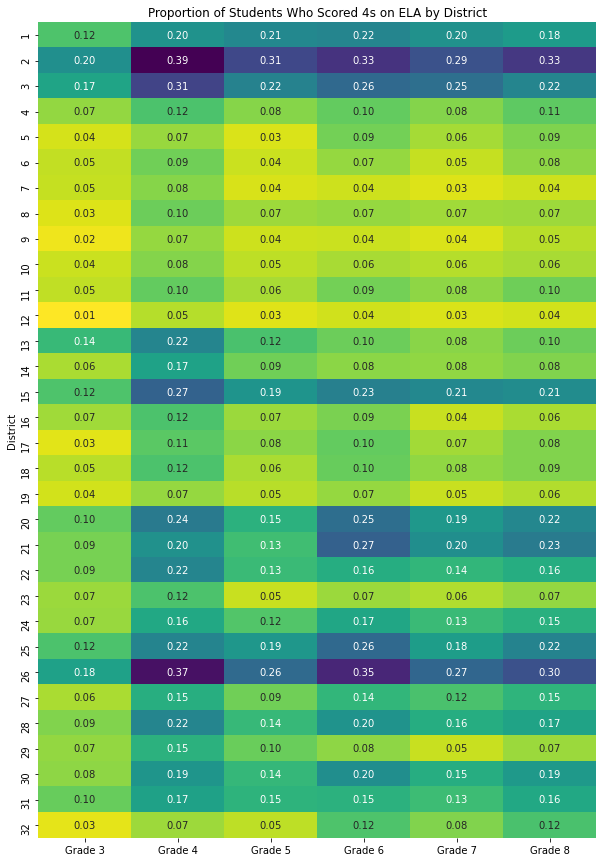

In [43]:
def create_grade_heatmap(subject):
    '''
    INPUT:
    subject (str) - subject to plot proportion of 4s by grade, either 'ELA' or 'Math'
    
    OUTPUT:
    None
    
    Create heatmaps that show the proportion of 4s in a subject by grade and district.
    '''
    
    subject_name = subject.lower()
    # store the column names that show how many students tested and how many students received 4s
    all_students_tested_cols = []
    all_students_4s_cols = []
    
    # go through each grade in the dataset and append the column names to the lists created above
    for i in range(3, 9):
        all_students_tested = 'grade_'+str(i)+'_'+subject_name+'_all_students_tested'
        all_students_4s = 'grade_'+str(i)+'_'+subject_name+'_4s_all_students'
        all_students_tested_cols.append(all_students_tested)
        all_students_4s_cols.append(all_students_4s)
        
    subject_4s_rate = schools.groupby('district')[all_students_tested_cols+all_students_4s_cols].sum()
    
    # go through each grade and calculate the proportion of students who received 4s
    for i in range(0, 6):
        subject_4s_rate['Grade '+str(i+3)] = \
            subject_4s_rate[all_students_4s_cols[i]]/subject_4s_rate[all_students_tested_cols[i]]
        subject_4s_rate.drop([all_students_tested_cols[i], all_students_4s_cols[i]], axis=1, inplace=True)
        
    plt.figure(figsize=[10, 15])
    sb.heatmap(subject_4s_rate, annot=True, fmt='.2f', cmap='viridis_r', cbar=False)
    plt.title('Proportion of Students Who Scored 4s on '+subject+' by District')
    plt.ylabel('District');
    
create_grade_heatmap('ELA')

Interestingly, grades 4, 6, and 8 seem to have stronger performance in ELA than the other grades, so it does not necessarily show continuous improvement. Districts 2 and 26 seem to have especially strong performance.

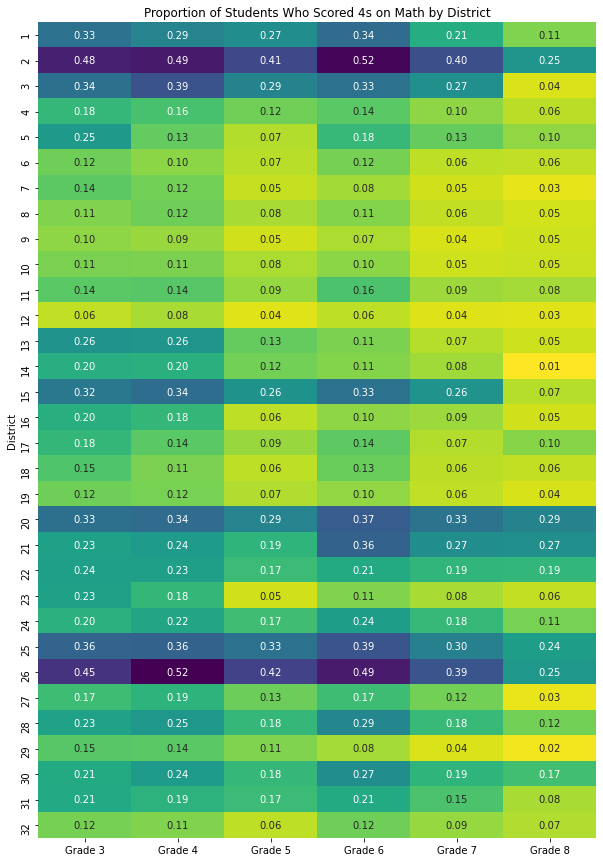

In [44]:
create_grade_heatmap('Math')

In math, grades 3, 4, and 6 seem to have stronger performance, and Districts 2 and 26 again have high scorers in math.

### SHSAT Offers Data

Now I will read in a dataset that was provided on [Kaggle](https://www.kaggle.com/infocusp/2017-2018-shsat-admissions-test-offers-by-schools) by a competitor, who got it from the combination of the New York Times and NYC Open. This data mainly shows, by school, the number of students who took the SHSAT and the number who received offers from specialized high schools.

In [45]:
shsat = pd.read_csv('2017-2018 SHSAT Admissions Test Offers By Sending School.csv')
shsat.head()

,School DBN,Borough,School Category,School Name,Number of students who took test,Number of students who received offer,Percent of eight grade students who received offer,Percentage of Black/Hispanic students
0,20K187,Brooklyn,Intermediate School 187,The Christa McAuliffe School,251.0,205.0,75%,8%
1,21K239,Brooklyn,Intermediate School 239,The Mark Twain Intermediate School for the Gif...,336.0,196.0,46%,13%
2,03M054,Manhattan,Junior High School 54,The Booker T. Washington School,257.0,150.0,53%,23%
3,15K051,Brooklyn,Midde School 51,The William Alexander School,280.0,122.0,33%,28%
4,02M312,Manhattan,NaN,New York City Lab Middle School for Collaborat...,163.0,113.0,62%,8%


In [46]:
shsat.shape

(589, 8)

Again, I want to rename the columns using the function I created earlier. I will also take a look at the number of missing values and data types.

In [47]:
shsat.rename(columns=lambda x: rename_col(x), inplace=True)
shsat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 8 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   school_dbn                                          589 non-null    object 
 1   borough                                             589 non-null    object 
 2   school_category                                     231 non-null    object 
 3   school_name                                         589 non-null    object 
 4   number_of_students_who_took_test                    537 non-null    float64
 5   number_of_students_who_received_offer               120 non-null    float64
 6   percent_of_eight_grade_students_who_received_offer  120 non-null    object 
 7   percentage_of_black_hispanic_students               589 non-null    object 
dtypes: float64(2), object(6)
memory usage: 36.9+ KB


In [48]:
# descriptive statistics for percentage of missing values in each column
shsat_prop_null = shsat.isnull().sum()/shsat.shape[0]
shsat_prop_null.describe()

count    8.000000
mean     0.286078
std      0.376179
min      0.000000
25%      0.000000
50%      0.044143
75%      0.654924
max      0.796265
dtype: float64

I was hoping that I might be able to create a model to determine important features for which schools receive more offers to specialized high schools. However, the `number_of_students_who_received_offer` column has many missing values, so it may not be as viable.

Also, the columns `percent_of_eight_grade_students_who_received_offer` and `percentage_of_black_hispanic_students` should be floats, but were read in as strings. I will use the `convert_percent_str` function that I created earlier to convert these columns.

In [49]:
percent_cols = ['percent_of_eight_grade_students_who_received_offer', 'percentage_of_black_hispanic_students']
for col in percent_cols:
    shsat[col] = convert_percent_str(shsat[col])

I will now compare `number_of_students_who_received_offer` to `number_of_students_who_took_test` to see if there are any instances in which offers are higher than the number of who took the SHSAT.

In [50]:
shsat.query('number_of_students_who_received_offer > number_of_students_who_took_test')

,school_dbn,borough,school_category,school_name,number_of_students_who_took_test,number_of_students_who_received_offer,percent_of_eight_grade_students_who_received_offer,percentage_of_black_hispanic_students


I will also make sure that there are no duplicated schools in the dataset based on `school_dbn`. I will not check `school_name` because I know that `school_dbn` is the unique identifier for each school based on the previous exploration.

In [51]:
shsat.duplicated(subset='school_dbn').sum()

0

I will also take a look at the descriptive statistics for `shsat` dataframe.

In [52]:
shsat.describe()

,number_of_students_who_took_test,number_of_students_who_received_offer,percent_of_eight_grade_students_who_received_offer,percentage_of_black_hispanic_students
count,537.000000,120.000000,120.000000,589.000000
mean,47.204842,33.425000,0.159917,0.764194
std,61.158551,37.105043,0.168021,0.268222
min,6.000000,6.000000,0.010000,0.080000
25%,15.000000,9.000000,0.060000,0.600000
50%,26.000000,19.500000,0.100000,0.920000
75%,46.000000,46.000000,0.182500,0.960000
max,394.000000,205.000000,0.760000,1.000000


The descriptive statistics look reasonable to me. I will now make some visualizations, starting with a count of schools by borough.

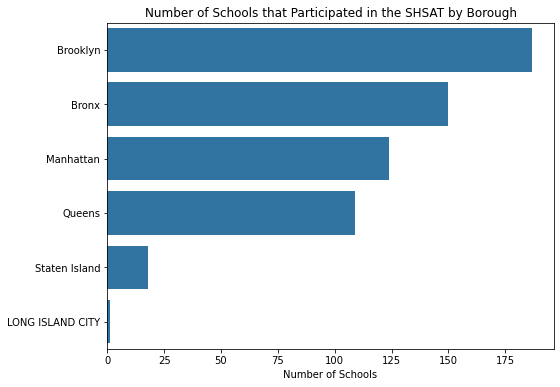

In [53]:
# get the order of boroughs based on the count of schools
borough_order = shsat['borough'].value_counts().index
ordered_borough = pd.api.types.CategoricalDtype(categories=borough_order, ordered=True)
shsat['borough'] = shsat['borough'].astype(ordered_borough)

plt.figure(figsize=[8, 6])
sb.countplot(data=shsat, y='borough', color=base_color)
plt.title('Number of Schools that Participated in the SHSAT by Borough')
plt.xlabel('Number of Schools')
plt.ylabel('');

shsat['borough'] = shsat['borough'].astype(str)

Staten Island and Long Island City stand out as having fewer schools compared to the other boroughs. After doing some [research](https://www.citypopulation.de/en/usa/newyorkcity/), it seems like this is reasonable given that these boroughs have much lower populations as well.

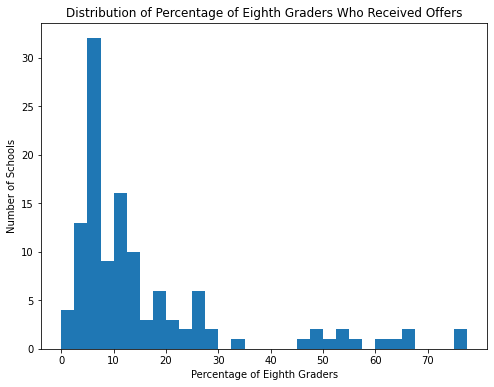

In [54]:
xticks = np.arange(0, 0.8, 0.1)
xtick_labels = np.arange(0, 80, 10)
bin_size = 0.025
bins = np.arange(0, shsat['percent_of_eight_grade_students_who_received_offer'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(data=shsat, x='percent_of_eight_grade_students_who_received_offer', bins=bins)
plt.xticks(xticks, xtick_labels)
plt.title('Distribution of Percentage of Eighth Graders Who Received Offers')
plt.xlabel('Percentage of Eighth Graders')
plt.ylabel('Number of Schools');

The distribution of eighth grade offers is right-skewed, with the peak at around 5%. However, there is also a small cluster of schools that had over 40% of students receive offers.

I will also look at the distribution of `percentage_of_black_hispanic_students`.

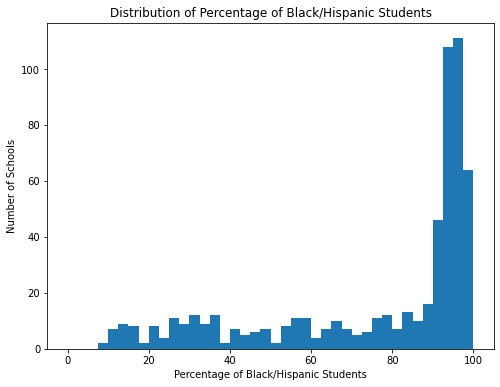

In [55]:
xticks = np.arange(0, 1.2, 0.2)
xtick_labels = np.arange(0, 120, 20)
bin_size = 0.025
bins = np.arange(0, shsat['percentage_of_black_hispanic_students'].max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(data=shsat, x='percentage_of_black_hispanic_students', bins=bins)
plt.xticks(xticks, xtick_labels)
plt.title('Distribution of Percentage of Black/Hispanic Students')
plt.xlabel('Percentage of Black/Hispanic Students')
plt.ylabel('Number of Schools');

The distribution is left-skewed, with the majority of schools having over 90% Black and Hispanic students. This makes sense given the heatmap earlier that showed that many districts have high percentages of these demographics.

Now I will start looking at the relationship between variables, starting with `percentage_of_black_hispanic_students` and `percent_of_eight_grade_students_who_received_offer`.

Proportion of Black/Hispanic Students vs. Proportion of Eighth Grade Students Who Received Offer
Pearson Correlation Coefficient: -0.4831221159376908, P-Value: 2.28650189335563e-08



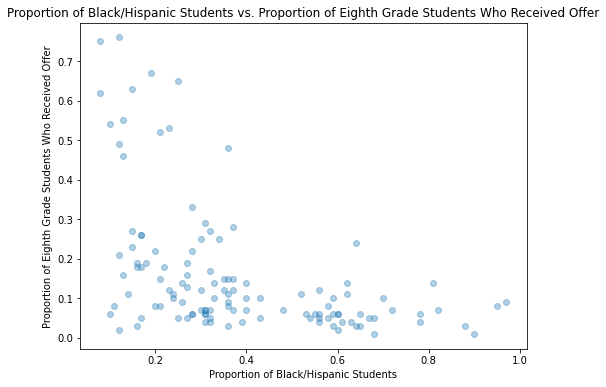

In [56]:
plot_scatter_stats(
    shsat,
    'percentage_of_black_hispanic_students',
    'percent_of_eight_grade_students_who_received_offer',
    'Proportion of Black/Hispanic Students',
    'Proportion of Eighth Grade Students Who Received Offer'
)

There is a decently strong negative correlation between the variables, meaning that schools with higher percentages of Black and Hispanic students also tend to receive fewer offers to specialized high schools.

I will also take a look at offers by borough.

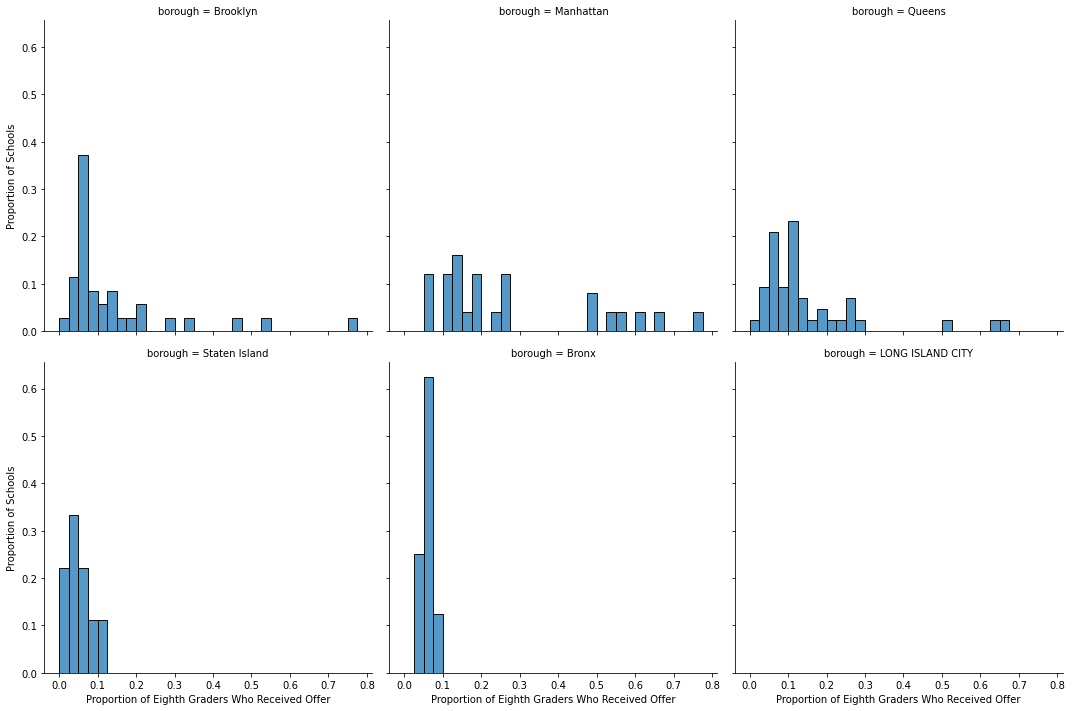

In [57]:
bin_size = 0.025
bins = np.arange(0, shsat['percent_of_eight_grade_students_who_received_offer'].max()+bin_size, bin_size)
g = sb.displot(
    data=shsat,
    x='percent_of_eight_grade_students_who_received_offer',
    col='borough',
    col_wrap=3,
    bins=bins,
    stat='probability',
    common_norm=False
)
g.set_axis_labels('Proportion of Eighth Graders Who Received Offer', 'Proportion of Schools');

Schools in Manhattan stand out as having higher percentages of students who receive offers, while Staten Island and Bronx have lower percentages. I will also take a look at the demographics for these boroughs.

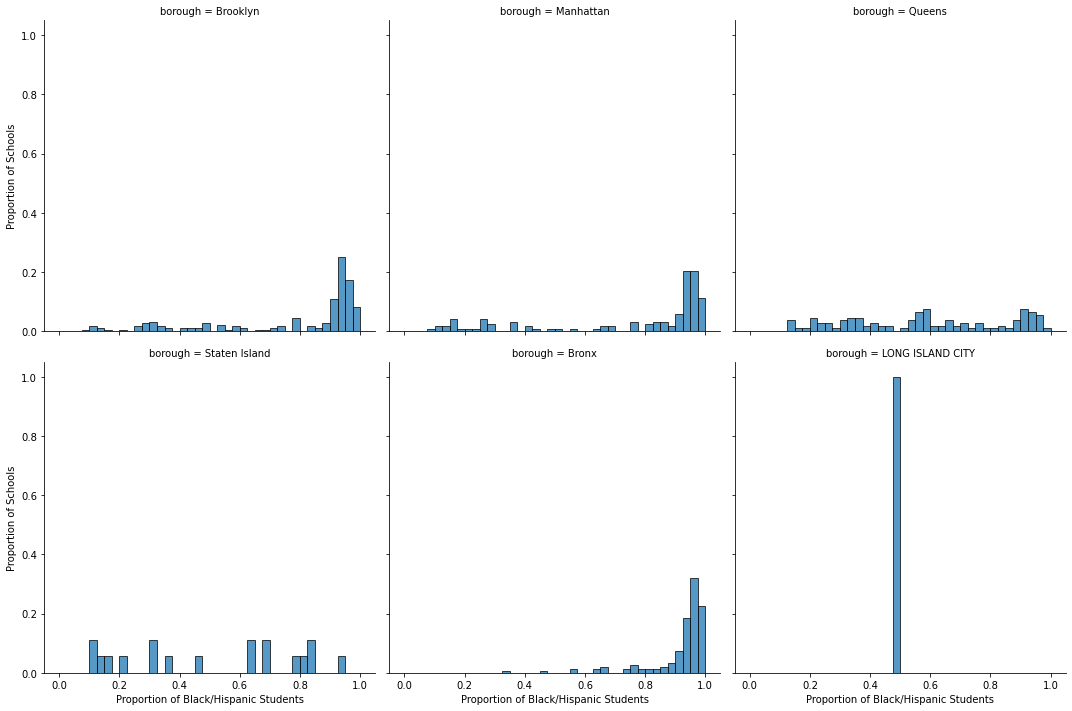

In [58]:
bin_size = 0.025
bins = np.arange(0, shsat['percentage_of_black_hispanic_students'].max()+bin_size, bin_size)
g = sb.displot(
    data=shsat,
    x='percentage_of_black_hispanic_students',
    col='borough',
    col_wrap=3,
    bins=bins,
    stat='probability',
    common_norm=False
)
g.set_axis_labels('Proportion of Black/Hispanic Students', 'Proportion of Schools');

The Bronx has a high number of schools with large Black and Hispanic populations, while the distributions for Queens and Staten Island are more evenly spread.

### Department of Education School Directory Data

Now I will take a look at a dataset on [Kaggle](https://www.kaggle.com/new-york-city/nyc-high-school-directory?select=2017_DOE_High_School_Directory.xlsx) that I found when looking at the discussion for the PASSNYC competition. This dataset is a directory that provides information on schools in New York City.

In [59]:
directory = pd.read_csv('2017-doe-high-school-directory.csv')
directory.head()

,dbn,school_name,boro,overview_paragraph,school_10th_seats,academicopportunities1,academicopportunities2,academicopportunities3,academicopportunities4,academicopportunities5,ell_programs,language_classes,advancedplacement_courses,diplomaendorsements,neighborhood,shared_space,campus_name,building_code,location,phone_number,fax_number,school_email,website,subway,bus,grades2018,finalgrades,total_students,start_time,end_time,addtl_info1,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,graduation_rate,attendance_rate,pct_stu_enough_variety,college_career_rate,pct_stu_safe,girls,boys,pbat,international,specialized,transfer,ptech,earlycollege,geoeligibility,school_accessibility_description,prgdesc1,prgdesc2,prgdesc3,prgdesc4,prgdesc5,prgdesc6,prgdesc7,prgdesc8,prgdesc9,prgdesc10,directions1,directions2,directions3,directions4,directions5,directions6,directions7,directions8,directions9,directions10,requirement1_1,requirement1_2,requirement1_3,requirement1_4,requirement1_5,requirement1_6,requirement1_7,requirement1_8,requirement1_9,requirement1_10,requirement2_1,requirement2_2,requirement2_3,requirement2_4,requirement2_5,requirement2_6,requirement2_7,requirement2_8,requirement2_9,requirement2_10,requirement3_1,requirement3_2,requirement3_3,requirement3_4,requirement3_5,requirement3_6,requirement3_7,requirement3_8,requirement3_9,requirement3_10,requirement4_1,requirement4_2,requirement4_3,requirement4_4,requirement4_5,requirement4_6,requirement4_7,requirement4_8,requirement4_9,requirement4_10,requirement5_1,requirement5_2,requirement5_3,requirement5_4,requirement5_5,requirement5_6,requirement5_7,requirement5_8,requirement5_9,requirement5_10,requirement6_1,requirement6_2,requirement6_3,requirement6_4,requirement6_5,requirement6_6,requirement6_7,requirement6_8,requirement6_9,requirement6_10,requirement7_1,requirement7_2,requirement7_3,requirement7_4,requirement7_5,requirement7_6,requirement7_7,requirement7_8,requirement7_9,requirement7_10,requirement8_1,requirement8_2,requirement8_3,requirement8_4,requirement8_5,requirement8_6,requirement8_7,requirement8_8,requirement8_9,requirement8_10,requirement9_1,requirement9_2,requirement9_3,requirement9_4,requirement9_5,requirement9_6,requirement9_7,requirement9_8,requirement9_9,requirement9_10,requirement10_1,requirement10_2,requirement10_3,requirement10_4,requirement10_5,requirement10_6,requirement10_7,requirement10_8,requirement10_9,requirement10_10,requirement11_1,requirement11_2,requirement11_3,requirement11_4,requirement11_5,requirement11_6,requirement11_7,requirement11_8,requirement11_9,requirement11_10,requirement12_1,requirement12_2,requirement12_3,requirement12_4,requirement12_5,requirement12_6,requirement12_7,requirement12_8,requirement12_9,requirement12_10,offer_rate1,offer_rate2,offer_rate3,offer_rate4,offer_rate5,offer_rate6,offer_rate7,offer_rate8,offer_rate9,offer_rate10,program1,program2,program3,program4,program5,program6,program7,program8,program9,program10,code1,code2,code3,code4,code5,code6,code7,code8,code9,code10,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,interest9,interest10,method1,method2,method3,method4,method5,method6,method7,method8,method9,method10,seats9ge1,seats9ge2,seats9ge3,seats9ge4,seats9ge5,seats9ge6,seats9ge7,seats9ge8,seats9ge9,seats9ge10,grade9gefilledflag1,grade9gefilledflag2,grade9gefilledflag3,grade9gefilledflag4,grade9gefilledflag5,grade9gefilledflag6,grade9gefilledflag7,grade9gefilledflag8,grade9gefilledflag9,grade9gefilledflag10,grade9geapplicants1,grade9geapplicants2,grade9geapplicants3,grade9geapplicants4,grade9geapplicants5,grade9geapplicants6,grade9geapplicants7,grade9geapplicants8,grade9geapplicants9,grade9geapplicants10,seats9swd1,seats9swd2,seats9swd3,seats9swd4,seats9swd5,seats9swd6,seats9swd7,seats9swd8,seats9swd9,seats9swd10,grade9swdfilledflag1,grade9swdfilledflag2,grade9swdfilledflag3,grade9swdfilledflag4,grade9swdfilledflag5,grade9swdfilledflag6,grade9swdfilled

In [60]:
directory.shape

(440, 462)

There are 462 columns in this dataset. I am not sure if I want to keep all of them, especially the ones that are copies of each other and have 10 iterations (for example `prgdesc1`, `prgdesc2`, etc.). So, I will print out each column name along with its number to figure out which columns I want to keep.

In [61]:
for col, idx in enumerate(directory.columns):
    print(col, idx)

0 dbn
1 school_name
2 boro
3 overview_paragraph
4 school_10th_seats
5 academicopportunities1
6 academicopportunities2
7 academicopportunities3
8 academicopportunities4
9 academicopportunities5
10 ell_programs
11 language_classes
12 advancedplacement_courses
13 diplomaendorsements
14 neighborhood
15 shared_space
16 campus_name
17 building_code
18 location
19 phone_number
20 fax_number
21 school_email
22 website
23 subway
24 bus
25 grades2018
26 finalgrades
27 total_students
28 start_time
29 end_time
30 addtl_info1
31 extracurricular_activities
32 psal_sports_boys
33 psal_sports_girls
34 psal_sports_coed
35 school_sports
36 graduation_rate
37 attendance_rate
38 pct_stu_enough_variety
39 college_career_rate
40 pct_stu_safe
41 girls
42 boys
43 pbat
44 international
45 specialized
46 transfer
47 ptech
48 earlycollege
49 geoeligibility
50 school_accessibility_description
51 prgdesc1
52 prgdesc2
53 prgdesc3
54 prgdesc4
55 prgdesc5
56 prgdesc6
57 prgdesc7
58 prgdesc8
59 prgdesc9
60 prgdesc10
6

In [62]:
directory = directory.iloc[:, np.r_[0:51, 449:462]]

In [63]:
directory.shape

(440, 64)

After removing the duplicated columns, I am now down to 64 columns. I will rename these columns and also drop some columns that will not be useful for building a model.

In [64]:
directory.rename(columns=lambda x: rename_col(x), inplace=True)

drop_cols = [
    'campus_name',
    'building_code',
    'location', 'phone_number',
    'fax_number',
    'school_email',
    'website',
    'geoeligibility',
    'primary_address_line_1',
    'state_code',
    'bin',
    'bbl'
]

directory.drop(drop_cols, axis=1, inplace=True)

I see that the columns `boro` and `borough` may be pretty similar. I will take a look below.

In [65]:
directory.groupby(['boro', 'borough']).size()

boro  borough  
K     BROOKLYN     124
M     MANHATTAN    107
Q     QUEENS        80
R     STATEN IS     10
X     BRONX        118
dtype: int64

In [66]:
directory[['boro', 'borough']].isnull().sum()

boro       0
borough    1
dtype: int64

The two columns are the same; the only difference is that the `borough` column has one missing value. Therefore, I will keep the `boro` column and also rename the values to make them more comprehensible.

In [67]:
# create dictionary to map borough abbreviations to names
borough_dict = {'K': 'Brooklyn', 'M': 'Manhattan', 'Q': 'Queens', 'R': 'Staten Island', 'X': 'Bronx'}
directory['boro'].replace(borough_dict, inplace=True)

In [68]:
directory.drop('borough', axis=1, inplace=True)

Similarly, the `neighborhood` and `nta` columns look like they could be similar. I will also take a look at these.

In [69]:
directory.groupby(['neighborhood', 'nta']).size()

neighborhood                       nta                                                                        
Annadale-Huguenot-Princes Bay      Annadale-Huguenot-Prince's Bay-Eltingville                                      1
Astoria                            Astoria                                                                         3
Auburndale                         Auburndale                                                                      2
Baisley Park                       Baisley Park                                                                    1
Bay Ridge                          Bay Ridge                                                                       2
Bayside-Bayside Hills              Bayside-Bayside Hills                                                           1
Bedford-Stuyvesant                 Bedford                                                                         1
                                   Crown Heights North                

As I suspected, these two columns are very similar. I will keep the `neighborhood` column, as the `nta` column seems more specific, and I would like a more generalized column.

In [70]:
directory.drop('nta', axis=1, inplace=True)

Now I will take a look at the number of missing values in each column.

In [71]:
directory.isnull().sum()

dbn                                   0
school_name                           0
boro                                  0
overview_paragraph                    0
school_10th_seats                   137
academicopportunities1                1
academicopportunities2               17
academicopportunities3               58
academicopportunities4              128
academicopportunities5              257
ell_programs                          0
language_classes                     18
advancedplacement_courses           121
diplomaendorsements                 323
neighborhood                          0
shared_space                         70
subway                               79
bus                                   1
grades2018                            0
finalgrades                           0
total_students                        0
start_time                            9
end_time                              9
addtl_info1                         142
extracurricular_activities            3


In [72]:
# descriptive statistics for percentage of missing values in each column
directory_prop_null = directory.isnull().sum()/directory.shape[0]
directory_prop_null.describe()

count    50.000000
mean      0.249500
std       0.357255
min       0.000000
25%       0.002273
50%       0.039773
75%       0.313068
max       0.990909
dtype: float64

Even though the median percentage of missing values is about 4.0%, the average is 25.0%. This means that there must be some outlier columns with high percentages of missing values that are skewing the mean.

The series of columns starting from `girls` and `earlycollege` seem to have many missing values. However, based on the head of the `directory` dataframe above, it seems like these may be boolean columns that are only marked if a school satisfies that condition. I will explore the data types of each column below, but otherwise I am comfortable with the above output for now.

In [73]:
directory.dtypes

dbn                                  object
school_name                          object
boro                                 object
overview_paragraph                   object
school_10th_seats                   float64
academicopportunities1               object
academicopportunities2               object
academicopportunities3               object
academicopportunities4               object
academicopportunities5               object
ell_programs                         object
language_classes                     object
advancedplacement_courses            object
diplomaendorsements                  object
neighborhood                         object
shared_space                         object
subway                               object
bus                                  object
grades2018                           object
finalgrades                          object
total_students                        int64
start_time                           object
end_time                        

I will print below the columns that I think should be boolean, along with the unique values in each to confirm.

In [74]:
flag_cols = [
    'school_10th_seats',
    'shared_space',
    'girls',
    'boys',
    'pbat',
    'international',
    'specialized',
    'transfer',
    'ptech',
    'earlycollege',
    'school_accessibility_description'
]

print('Unique values by column\n')
for col in flag_cols:
    print('{}: {}'.format(col, directory[col].unique()))

Unique values by column

school_10th_seats: [ 1. nan]
shared_space: [nan 'Yes']
girls: [nan  1.]
boys: [nan  1.]
pbat: [nan  1.]
international: [nan  1.]
specialized: [nan  1.]
transfer: [nan  1.]
ptech: [nan  1.]
earlycollege: [nan  1.]
school_accessibility_description: [ 1. nan]


This confirms that the listed columns all should be boolean. It looks like all of them have a given value for `True`, and are null for `False`. I will convert them below.

In [75]:
for col in flag_cols:
    if col == 'shared_space':
        directory[col] = directory[col] == 'Yes'
    else:
        directory[col] = directory[col] == 1

The time-related columns, `start_time` and `end_time`, are strings right now. I will print out the unique values in these columns to see how they are formatted.

In [76]:
directory['start_time'].unique()

array([nan, '8:20am', '8:10am', '9am', '8am', '8:30am', '8:15am',
       '8:55am', '7:45am', '8:38am', '7:30am', '9:03am', '8:14am',
       '8:35am', '8:45am', '9:15am', '8:07am', '7:50am', '8:24am',
       '8:40am', '8:25am', '8:32am', '7:15am', '8:11am', '8:50am',
       '8:05am', '9:25am', '8:19am', '7:40am', '8:13am', '8:20pm',
       '9:02am', '9:08am', '7:20am', '8:29am', '7:55am', '9:50am',
       '8:41am', '8:23am', '9:05am', '8:48am', '9:22am', '8:51am',
       '8:49am', '8:22am', '7:28am', '9:30am', '9:10am'], dtype=object)

In [77]:
directory['end_time'].unique()

array([nan, '2:45pm', '3pm', '4pm', '3:10pm', '3:20pm', '3:55pm',
       '3:36pm', '3:30pm', '2:30pm', '2:20pm', '3:15pm', '3:35pm',
       '3:45pm', '2:57pm', '3:23pm', '2:40pm', '4:30pm', '3:05pm',
       '2:50pm', '3:40pm', '2:38pm', '3:09pm', '2:56pm', '3:37pm',
       '3:18pm', '3:53pm', '2:53pm', '4:15pm', '3:50pm', '3:29pm',
       '4:05pm', '2:35pm', '4:10pm', '3:27pm', '2:15pm', '2:37pm',
       '3:22pm', '3:47pm', '3:04pm', '3:12pm', '4:08pm', '1:40pm',
       '2:11pm', '3:25pm', '3:14pm', '3:07pm', '4:28pm', '3:31pm',
       '2:51pm', '2:42pm', '2:58pm', '2:48pm', '3:19pm', '3:08pm',
       '3:38pm', '4:40pm', '4:06pm', '2:05pm', '3:21pm', '3:39pm',
       '3:26pm', '2:39pm', '3:41pm', '3:11pm', '1:50pm', '5pm', '4:45pm',
       '3:32pm', '5:30pm'], dtype=object)

Now that I know the time formats, I will create a function to convert the data types.

In [78]:
def convert_time_str(text):
    '''
    INPUT:
    text (str) - time as a string
    
    OUTPUT:
    time_converted (time) - time with the data type converted
    
    Convert text from a string to a time.
    '''
    try:
        if text[-2:] == 'am':
            if ':' in text:
                h = int(text[:text.index(':')])
                m = int(text[text.index(':')+1:-2])
            else:
                h = int(text[:-2])
                m = 0
        elif text[-2:] == 'pm':
            if ':' in text:
                h = int(text[:text.index(':')])+12
                m = int(text[text.index(':')+1:-2])
            else:
                h = int(text[:-2])+12
                m = 0
        time_converted = time(h, m)
        return time_converted
    except:
        return pd.NaT
    
directory['start_time'] = directory['start_time'].apply(convert_time_str)
directory['end_time'] = directory['end_time'].apply(convert_time_str)

In [79]:
directory.dtypes

dbn                                  object
school_name                          object
boro                                 object
overview_paragraph                   object
school_10th_seats                      bool
academicopportunities1               object
academicopportunities2               object
academicopportunities3               object
academicopportunities4               object
academicopportunities5               object
ell_programs                         object
language_classes                     object
advancedplacement_courses            object
diplomaendorsements                  object
neighborhood                         object
shared_space                           bool
subway                               object
bus                                  object
grades2018                           object
finalgrades                          object
total_students                        int64
start_time                           object
end_time                        

The data types look fine for now. I will make sure there are no duplicated `dbn` (the unique identifier for each school) and also look at the descriptive statistics.

In [80]:
directory.duplicated(subset='dbn').sum()

0

In [81]:
directory.describe()

,total_students,graduation_rate,attendance_rate,pct_stu_enough_variety,college_career_rate,pct_stu_safe,postcode,latitude,longitude,community_board,council_district,census_tract
count,440.000000,383.000000,440.000000,439.000000,369.000000,439.000000,440.000000,437.000000,438.000000,439.000000,439.000000,439.000000
mean,687.413636,0.752441,0.869977,0.764032,0.566718,0.844920,10726.445455,40.744830,-73.921882,6.835991,21.854214,4032.735763
std,748.838354,0.156547,0.065104,0.110720,0.189703,0.081167,538.423132,0.081446,0.071268,4.392862,14.453568,15513.801536
min,77.000000,0.246000,0.540000,0.320000,0.210000,0.580000,10002.000000,40.528150,-74.193400,1.000000,1.000000,1.000000
25%,353.000000,0.636000,0.830000,0.700000,0.416000,0.790000,10301.000000,40.689180,-73.978600,3.000000,10.000000,118.000000
50%,451.500000,0.750000,0.880000,0.780000,0.536000,0.850000,10472.000000,40.740880,-73.926100,6.000000,18.000000,269.000000
75%,615.250000,0.885000,0.920000,0.840000,0.719000,0.910000,11218.500000,40.820490,-73.884600,10.000000,34.000000,518.000000
max,5534.000000,1.000000,0.980000,1.000000,1.000000,1.000000,11694.000000,40.888240,-73.728800,18.000000,51.000000,138501.000000


These descriptive statistics look reasonable, so I will move onto creating visualizations. First, I will take a look at the number of schools in the dataset by borough.

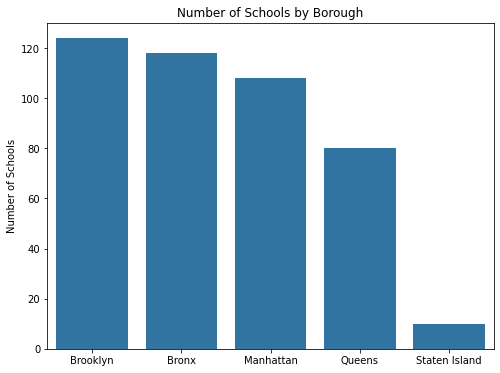

In [82]:
boro_order = directory['boro'].value_counts().index
ordered_boro = pd.api.types.CategoricalDtype(categories=boro_order, ordered=True)
directory['boro'] = directory['boro'].astype(ordered_boro)

plt.figure(figsize=[8, 6])
sb.countplot(data=directory, x='boro', color=base_color)
plt.title('Number of Schools by Borough')
plt.xlabel('')
plt.ylabel('Number of Schools');

directory['boro'] = directory['boro'].astype(str)

This visualization confirms the findings from before that Staten Island has, by far, the fewest number of schools.

I also want to see the number of schools by `city`.

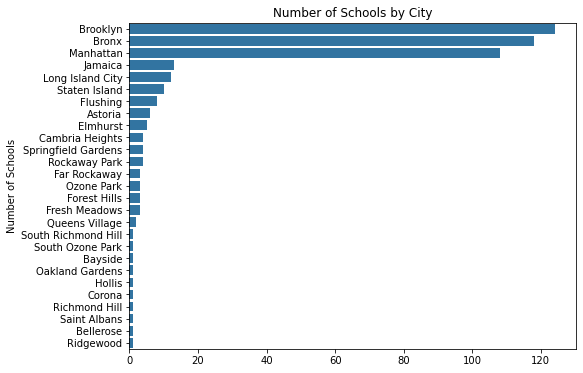

In [83]:
city_order = directory['city'].value_counts().index
ordered_city = pd.api.types.CategoricalDtype(categories=city_order, ordered=True)
directory['city'] = directory['city'].astype(ordered_city)

plt.figure(figsize=[8, 6])
sb.countplot(data=directory, y='city', color=base_color)
plt.title('Number of Schools by City')
plt.xlabel('')
plt.ylabel('Number of Schools');

directory['city'] = directory['city'].astype(str)

Interestingly, it seems like Queens is the only borough that is broken down into individual cities. The other boroughs show up in the `city` column, shown by the high number of schools in Brooklyn, Bronx, and Manhattan.

Now I will look at the distribution of number of students per school.

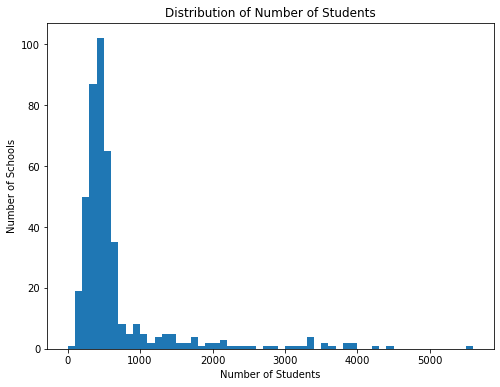

In [84]:
plt.figure(figsize=[8, 6])
bin_size = 100
bins = np.arange(0, directory['total_students'].max()+bin_size, bin_size)
plt.hist(data=directory, x='total_students', bins=bins)
plt.title('Distribution of Number of Students')
plt.xlabel('Number of Students')
plt.ylabel('Number of Schools');

The distribution is right-skewed and most schools have fewer than 1,000 students, with the peak coming at around 500 students. However, it is important to note that there is a school with over 5,000 students.

Now I will look at the distribution of the percentage of students who feel safe.

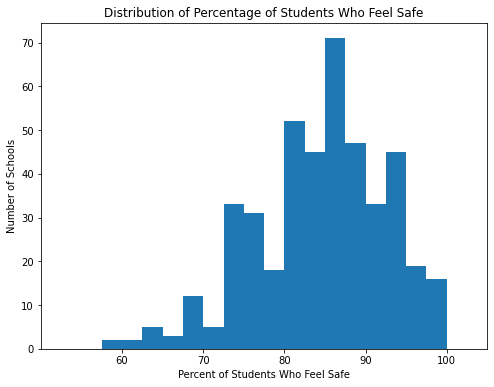

In [85]:
plt.figure(figsize=[8, 6])
xticks = np.arange(0.6, 1.2, 0.1)
xtick_labels = np.arange(60, 120, 10)
bin_size = 0.025
bins = np.arange(0.5, directory['pct_stu_safe'].max()+bin_size, bin_size)
plt.hist(data=directory, x='pct_stu_safe', bins=bins)
plt.title('Distribution of Percentage of Students Who Feel Safe')
plt.xlabel('Percent of Students Who Feel Safe')
plt.ylabel('Number of Schools')
plt.xticks(xticks, xtick_labels)
plt.xlim(0.5, 1.05);

The distribution appears to be more left-skewed, meaning that students seem to feel safe in general. The peak of the distribution is around 90%.

Now I will look at the distribution of `attendance_rate`.

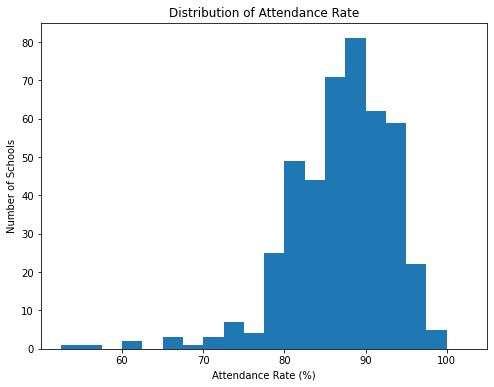

In [86]:
plt.figure(figsize=[8, 6])
xticks = np.arange(0.6, 1.2, 0.1)
xtick_labels = np.arange(60, 120, 10)
bin_size = 0.025
bins = np.arange(0.5, directory['attendance_rate'].max()+bin_size, bin_size)
plt.hist(data=directory, x='attendance_rate', bins=bins)
plt.title('Distribution of Attendance Rate')
plt.xlabel('Attendance Rate (%)')
plt.ylabel('Number of Schools')
plt.xticks(xticks, xtick_labels)
plt.xlim(0.5, 1.05);

The `attendance_rate` is also slightly left-skewed, and most schools have generally high attendance. The peak is at around 90% attendance.

I will also look at the distribution of `graduation_rate`.

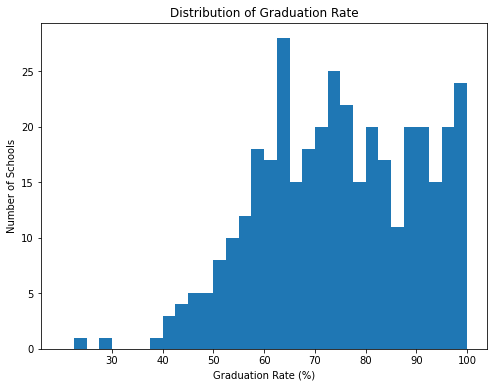

In [87]:
plt.figure(figsize=[8, 6])
xticks = np.arange(0.3, 1.1, 0.1)
xtick_labels = np.arange(30, 110, 10)
bin_size = 0.025
bins = np.arange(0.2, directory['graduation_rate'].max()+bin_size, bin_size)
plt.hist(data=directory, x='graduation_rate', bins=bins)
plt.title('Distribution of Graduation Rate')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Number of Schools')
plt.xticks(xticks, xtick_labels);

The `graduation_rate` is more uniformly distribution, with a tail towards the left of the distribution. In general, most schools have a `graduation_rate` higher than 60%.

I will now look at the distribution of `college_career_rate`.

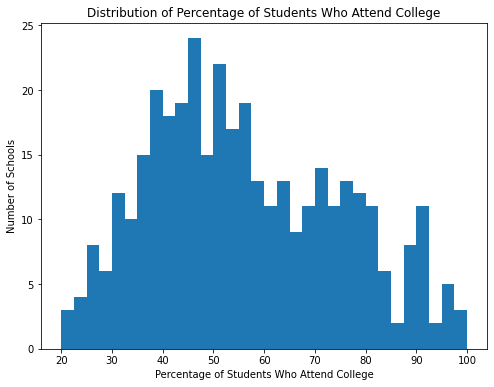

In [88]:
plt.figure(figsize=[8, 6])
xticks = np.arange(0.2, 1.1, 0.1)
xtick_labels = np.arange(20, 110, 10)
bin_size = 0.025
bins = np.arange(0.2, directory['college_career_rate'].max()+bin_size, bin_size)
plt.hist(data=directory, x='college_career_rate', bins=bins)
plt.title('Distribution of Percentage of Students Who Attend College')
plt.xlabel('Percentage of Students Who Attend College')
plt.ylabel('Number of Schools')
plt.xticks(xticks, xtick_labels);

This distribution is not quite normally distributed, but it is also difficult to tell if the tail is on the left or right side. The peak of `college_career_rate` is located around 50%.

I will also take a look at the number of unique values in `community_board`, `council_district`, and `census_tract` to see if they are worth plotting.

In [89]:
directory['community_board'].nunique()

18

In [90]:
directory['council_district'].nunique()

51

In [91]:
directory['census_tract'].nunique()

207

There are too many unique values in `council_district` and `census_tract`, so I will drop those and only plot the number of schools by `community_board`.

In [92]:
directory.drop(['council_district', 'census_tract'], axis=1, inplace=True)

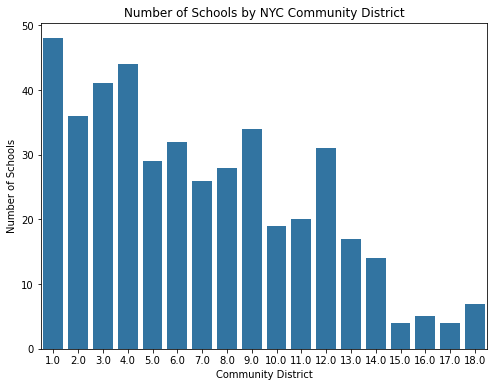

In [93]:
plt.figure(figsize=[8, 6])
sb.countplot(data=directory, x='community_board', color=base_color)
plt.title('Number of Schools by NYC Community District')
plt.xlabel('Community District')
plt.ylabel('Number of Schools');

In general, it seems like the higher the district number, the fewer schools there are.

Now I will look at a few multivariate visualizations, starting with the distribution of number of students by borough.

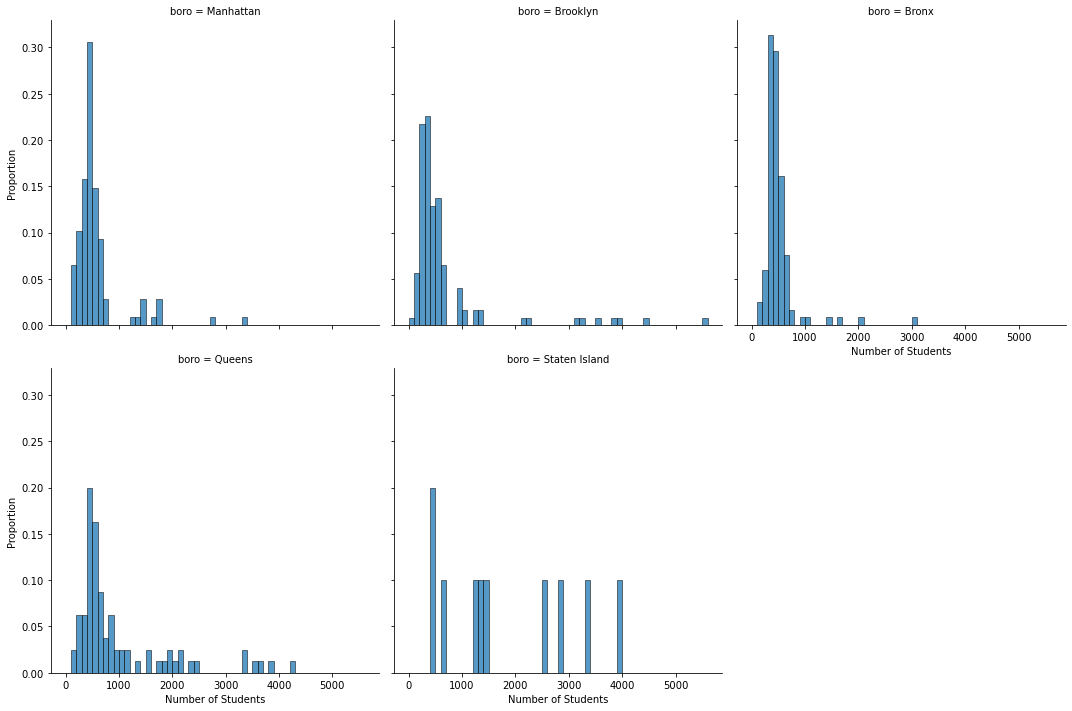

In [94]:
bin_size = 100
bins = np.arange(0, directory['total_students'].max()+bin_size, bin_size)
g = sb.displot(
    data=directory,
    x='total_students',
    col='boro',
    col_wrap=3,
    bins=bins,
    stat='probability',
    common_norm=False
)
g.set_axis_labels('Number of Students', 'Proportion');

The Bronx and Manhattan seem to have a higher concentration of schools with lower amounts of students, whereas Queens and Staten Island tend to have schools with higher numbers of students.

I will also take a look at the relationship between `pct_stu_safe` and `attendance_rate`.

Proportion of Students Who Feel Safe vs. Attendance Rate
Pearson Correlation Coefficient: 0.3039371363151393, P-Value: 7.793009490375231e-11



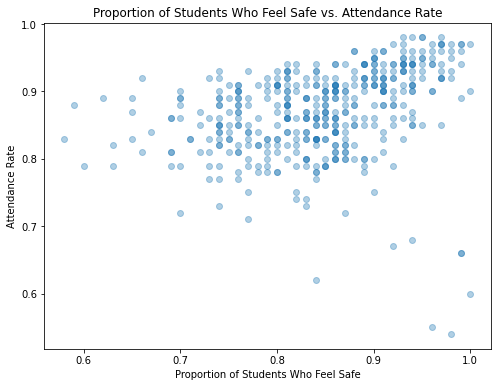

In [95]:
plot_scatter_stats(
    directory,
    'pct_stu_safe',
    'attendance_rate',
    'Proportion of Students Who Feel Safe',
    'Attendance Rate'
)

There is a positive correlation between the two variables, meaning that schools that feel safer tend to have higher attendance rates. However, this correlation is not strong.

Now I will look at the relationship between `attendance_rate` and `graduation_rate`.

Attendance Rate vs. Graduation Rate
Pearson Correlation Coefficient: 0.8030711363554569, P-Value: 1.1020529654475788e-87



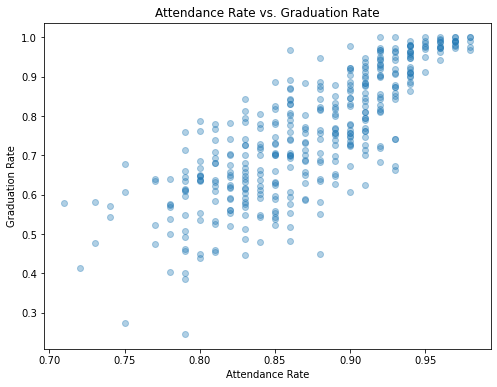

In [96]:
plot_scatter_stats(directory, 'attendance_rate', 'graduation_rate', 'Attendance Rate', 'Graduation Rate')

There is a strong positive relationship between these variables. As the `attendance rate` of a school increases, the `graduation_rate` also tends to increase.

Finally, I will look at the relationship between `graduation_rate` and `college_career_rate`.

Graduation Rate vs. Proportion of Students Who Attend College
Pearson Correlation Coefficient: 0.8381748976326309, P-Value: 1.1759368510823651e-98



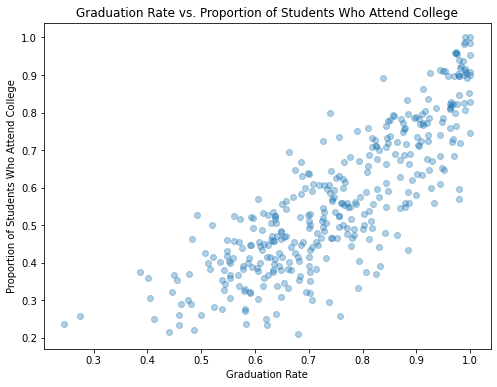

In [97]:
plot_scatter_stats(
    directory,
    'graduation_rate',
    'college_career_rate',
    'Graduation Rate',
    'Proportion of Students Who Attend College'
)

There is also a strong positive correlation between these variables. As more students graduate, there is also a higher percentage of students who attend college.

### Combining the Data

Now I will combine the `schools`, `shsat`, and `directory` dataframes to create a final dataset that can be used for modeling. I will limit this to the subset of schools that are included in all of the dataframes, because I will need multiple datasets to create the target variable.

In [98]:
final_df = directory.merge(shsat, how='inner', left_on='dbn', right_on='school_dbn')
final_df = final_df.merge(schools, how='inner', left_on='dbn', right_on='location_code')
final_df.head()

,dbn,school_name_x,boro,overview_paragraph,school_10th_seats,academicopportunities1,academicopportunities2,academicopportunities3,academicopportunities4,academicopportunities5,ell_programs,language_classes,advancedplacement_courses,diplomaendorsements,neighborhood,shared_space,subway,bus,grades2018,finalgrades,total_students,start_time,end_time,addtl_info1,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,graduation_rate,attendance_rate,pct_stu_enough_variety,college_career_rate,pct_stu_safe,girls,boys,pbat,international,specialized,transfer,ptech,earlycollege,school_accessibility_description,city_x,postcode,latitude_x,longitude_x,community_board,school_dbn,borough,school_category,school_name_y,number_of_students_who_took_test,number_of_students_who_received_offer,percent_of_eight_grade_students_who_received_offer,percentage_of_black_hispanic_students,new,school_name,location_code,district,latitude_y,longitude_y,city_y,zip,grades,grade_low,grade_high,community_school,economic_need_index,school_income_estimate,percent_ell,percent_asian,percent_black,percent_hispanic,percent_black_hispanic,percent_white,student_attendance_rate,percent_of_students_chronically_absent,rigorous_instruction_percent,rigorous_instruction_rating,collaborative_teachers_percent,collaborative_teachers_rating,supportive_environment_percent,supportive_environment_rating,effective_school_leadership_percent,effective_school_leadership_rating,strong_family_community_ties_percent,strong_family_community_ties_rating,trust_percent,trust_rating,student_achievement_rating,average_ela_proficiency,average_math_proficiency,grade_3_ela_all_students_tested,grade_3_ela_4s_all_students,grade_3_ela_4s_american_indian_or_alaska_native,grade_3_ela_4s_black_or_african_american,grade_3_ela_4s_hispanic_or_latino,grade_3_ela_4s_asian_or_pacific_islander,grade_3_ela_4s_white,grade_3_ela_4s_multiracial,grade_3_ela_4s_limited_english_proficient,grade_3_ela_4s_economically_disadvantaged,grade_3_math_all_students_tested,grade_3_math_4s_all_students,grade_3_math_4s_american_indian_or_alaska_native,grade_3_math_4s_black_or_african_american,grade_3_math_4s_hispanic_or_latino,grade_3_math_4s_asian_or_pacific_islander,grade_3_math_4s_white,grade_3_math_4s_multiracial,grade_3_math_4s_limited_english_proficient,grade_3_math_4s_economically_disadvantaged,grade_4_ela_all_students_tested,grade_4_ela_4s_all_students,grade_4_ela_4s_american_indian_or_alaska_native,grade_4_ela_4s_black_or_african_american,grade_4_ela_4s_hispanic_or_latino,grade_4_ela_4s_asian_or_pacific_islander,grade_4_ela_4s_white,grade_4_ela_4s_multiracial,grade_4_ela_4s_limited_english_proficient,grade_4_ela_4s_economically_disadvantaged,grade_4_math_all_students_tested,grade_4_math_4s_all_students,grade_4_math_4s_american_indian_or_alaska_native,grade_4_math_4s_black_or_african_american,grade_4_math_4s_hispanic_or_latino,grade_4_math_4s_asian_or_pacific_islander,grade_4_math_4s_white,grade_4_math_4s_multiracial,grade_4_math_4s_limited_english_proficient,grade_4_math_4s_economically_disadvantaged,grade_5_ela_all_students_tested,grade_5_ela_4s_all_students,grade_5_ela_4s_american_indian_or_alaska_native,grade_5_ela_4s_black_or_african_american,grade_5_ela_4s_hispanic_or_latino,grade_5_ela_4s_asian_or_pacific_islander,grade_5_ela_4s_white,grade_5_ela_4s_multiracial,grade_5_ela_4s_limited_english_proficient,grade_5_ela_4s_economically_disadvantaged,grade_5_math_all_students_tested,grade_5_math_4s_all_students,grade_5_math_4s_american_indian_or_alaska_native,grade_5_math_4s_black_or_african_american,grade_5_math_4s_hispanic_or_latino,grade_5_math_4s_asian_or_pacific_islander,grade_5_math_4s_white,grade_5_math_4s_multiracial,grade_5_math_4s_limited_english_proficient,grade_5_math_4s_economically_disadvantaged,grade_6_ela_all_students_tested,grade_6_ela_4s_all_students,grade_6_ela_4s_american_indian_or_alaska_native,grade_6_ela_4s_black_or_african_american,grade_6_ela_4s_hispanic_or_latino,

In [99]:
final_df.shape

(81, 213)

I am left with 81 schools in the final dataset. Now I will create the target variable, which is the percentage of eligible students who took the SHSAT. There is a `total_students` column, but this includes all grades, and only eighth and ninth grade students can take the exam. Therefore, I will need to find the number of grades at the school and then figure out the approximate number of students per grade. I will look at the unique values in the column `grades2018` to see how I might be able to do this.

In [100]:
final_df['grades2018'].unique()

array(['6-11', '6-12', '6-10', 'K-12', 'PK-12', 'PK-3, 6-12', '7-12'],
      dtype=object)

I will create a dictionary to map the unique strings to an integer representing the number of grades. Then I can find the number of students per grade and consequently the number of eligible students for the SHSAT. Finally, I can calculate the proportion of eligible students who took the exam by using `number_of_students_who_took_test`.

In [101]:
# dictionary to map strings to number of grades
num_grades_dict = {'6-11': 6, '6-12': 7, '6-10': 5, 'K-12': 13, 'PK-12': 14, 'PK-3, 6-12': 12, '7-12': 6}
final_df['num_grades'] = final_df['grades2018'].replace(num_grades_dict)
final_df['students_per_grade'] = final_df['total_students']/final_df['num_grades']
# multiply students_per_grade by 2 to get the number of eligible students
final_df['prop_took_test'] = final_df['number_of_students_who_took_test']/(final_df['students_per_grade']*2)

There may be some rows in the dataset that are null for `prop_took_test`, so I will drop those.

In [102]:
final_df.dropna(subset=['prop_took_test'], inplace=True)
final_df.shape

(67, 216)

I am now left with 67 schools in the dataset.

I will now do some data wrangling to finalize which features I actually want to include in the model. But first, I want to look at the distribution of the percentage of eligible students who took the SHSAT.

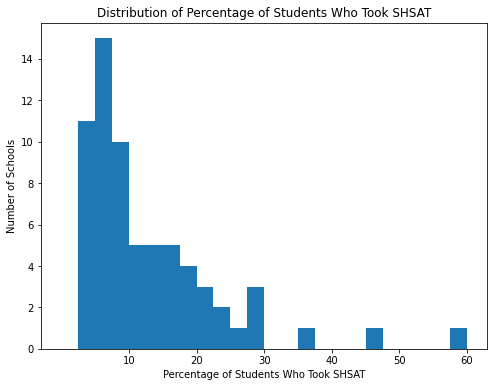

In [103]:
plt.figure(figsize=[8, 6])
xticks = np.arange(0.1, 0.7, 0.1)
xtick_labels = np.arange(10, 70, 10)
bin_size = 0.025
bins = np.arange(0, final_df['prop_took_test'].max()+bin_size, bin_size)
plt.hist(data=final_df, x='prop_took_test', bins=bins)
plt.title('Distribution of Percentage of Students Who Took SHSAT')
plt.xlabel('Percentage of Students Who Took SHSAT')
plt.ylabel('Number of Schools')
plt.xticks(xticks, xtick_labels);

It looks like the distribution is right-skewed, so most schools had lower percentages of students who took the SHSAT. However, there are a few schools that had over 30% of students take the exam.

I see that there are two similar columns called `city_x` and `city_y`. I will compare these to see which, if any, I want to keep.

In [104]:
id_cols = ['dbn', 'school_name', 'school_name_x', 'school_name_y', 'city_x', 'city_y']
final_df[final_df['city_x'].str.lower() != final_df['city_y'].str.lower()][id_cols]

,dbn,school_name,school_name_x,school_name_y,city_x,city_y
0,02M260,M.S. 260 CLINTON SCHOOL WRITERS & ARTISTS,"Clinton School Writers & Artists, M.S. 260",The Clinton School Writers and Artists,Manhattan,NEW YORK
5,01M450,EAST SIDE COMMUNITY SCHOOL,East Side Community School,East Side Community School,Manhattan,NEW YORK
6,25Q252,"QUEENS SCHOOL OF INQUIRY, THE","Queens School of Inquiry, The",Queens School of Inquiry,Fresh Meadows,FLUSHING
8,02M408,PROFESSIONAL PERFORMING ARTS HIGH SCHOOL,Professional Performing Arts High School (PPAS),Professional Performing Arts High School,Manhattan,NEW YORK
12,02M413,SCHOOL OF THE FUTURE HIGH SCHOOL,School of the Future High School,School of the Future High School,Manhattan,NEW YORK
13,02M422,QUEST TO LEARN,Quest to Learn,Quest to Learn,Manhattan,NEW YORK
15,05M148,EAGLE ACADEMY FOR YOUNG MEN OF HARLEM,Eagle Academy for Young Men of Harlem,Eagle Academy for Young Men of Harlem,Manhattan,NEW YORK
18,06M346,COMMUNITY HEALTH ACADEMY OF THE HEIGHTS,Community Health Academy of the Heights,Community Health Academy of the Heights,Manhattan,NEW YORK
19,03M859,SPECIAL MUSIC SCHOOL,Special Music School,Special Music School,Manhattan,NEW YORK
29,30Q286,"YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA","Young Women's Leadership School, Astoria (TYWLS)","Young Women's Leadership School, Astoria",Astoria,LONG ISLAND CITY


The column `city_x` seems more desriptive, especially because "NEW YORK" is the name of the entire city. I will drop `city_y`.

In [105]:
final_df.drop('city_y', axis=1, inplace=True)

There is a similar issue with the columns `boro` and `borough`, so I will take a look at that.

In [106]:
id_cols.remove('city_y')
final_df[final_df['boro'] != final_df['borough']][id_cols]

,dbn,school_name,school_name_x,school_name_y,city_x


It look like all of the values are the same, so it does not matter which column I drop.

In [107]:
final_df.drop('boro', axis=1, inplace=True)

There are also benchmark columns for percents and ratings. For example, there is `rigorous_instruction_percent` and `rigorous_instruction_rating`. I will take a look at these to see if they are duplicates and if there is any pattern.

In [108]:
final_df[['rigorous_instruction_percent', 'rigorous_instruction_rating']]

,rigorous_instruction_percent,rigorous_instruction_rating
0,0.91,Exceeding Target
1,0.94,Exceeding Target
2,0.82,Meeting Target
3,0.85,Meeting Target
4,0.92,Exceeding Target
5,0.92,Exceeding Target
6,0.81,Meeting Target
8,0.90,Meeting Target
10,0.94,Exceeding Target
11,0.89,Exceeding Target


I do not see a clear pattern to the `rigorous_instruction_rating`. There is one school that has 83% and is "Approaching Target", while there is another schools that is at 82% and is "Meeting Target". The percentage column provides me with better information, so I will drop all of the ratings columns that have similar percentage columns.

In [109]:
drop_cols = [
    'rigorous_instruction_rating',
    'collaborative_teachers_rating',
    'supportive_environment_rating',
    'effective_school_leadership_rating',
    'strong_family_community_ties_rating',
    'trust_rating'
]

final_df.drop(drop_cols, axis=1, inplace=True)

I also want to take a look at the columns that detail how many students tested in each exam in each grade (for example, `grade_3_ela_all_students_tested`). I will eventually want to create columns that show what percentage of these students received 4s. However, if no students took the given test, then the information is not particularly useful. Therefore, I will see how many rows have 0 in these columns.

In [110]:
all_students_tested_cols = []
for i in range(3, 9):
    for subject in ['ela', 'math']:
        all_students_tested_cols.append('grade_'+str(i)+'_'+subject+'_all_students_tested')
(final_df[all_students_tested_cols] == 0).sum()

grade_3_ela_all_students_tested     64
grade_3_math_all_students_tested    64
grade_4_ela_all_students_tested     64
grade_4_math_all_students_tested    64
grade_5_ela_all_students_tested     64
grade_5_math_all_students_tested    65
grade_6_ela_all_students_tested      1
grade_6_math_all_students_tested     1
grade_7_ela_all_students_tested      0
grade_7_math_all_students_tested     1
grade_8_ela_all_students_tested      0
grade_8_math_all_students_tested    14
dtype: int64

Given that there are only 67 schools in the dataset, the data for grades 3-5 are not helpful because most rows have 0. Therefore, I will drop those columns.

In [111]:
for i in range(3, 6):
    drop_cols = final_df.columns[final_df.columns.str.startswith('grade_'+str(i))]
    final_df.drop(drop_cols, axis=1, inplace=True)

Now I will take a look at the proportion of missing values in each column to decide if they are useful, as well as determine if I need to do any imputation.

In [112]:
final_df.isnull().sum()/final_df.shape[0]

dbn                                                   0.000000
school_name_x                                         0.000000
overview_paragraph                                    0.000000
school_10th_seats                                     0.000000
academicopportunities1                                0.000000
academicopportunities2                                0.044776
academicopportunities3                                0.179104
academicopportunities4                                0.358209
academicopportunities5                                0.716418
ell_programs                                          0.000000
language_classes                                      0.044776
advancedplacement_courses                             0.283582
diplomaendorsements                                   0.791045
neighborhood                                          0.000000
shared_space                                          0.000000
subway                                                0

I will drop several columns because they are duplicated elsewhere in the dataset, have too many missing values, or will not be useful for the model.

In [113]:
drop_cols = [
    'dbn',
    'school_name_x',
    'overview_paragraph',
    'postcode',
    'latitude_x',
    'longitude_x',
    'community_board',
    'school_dbn',
    'school_category',
    'school_name_y',
    'number_of_students_who_took_test',
    'number_of_students_who_received_offer',
    'percent_of_eight_grade_students_who_received_offer',
    'percentage_of_black_hispanic_students',
    'school_name',
    'location_code',
    'district',
    'zip',
    'grades',
    'grade_low',
    'grade_high',
    'school_income_estimate'
]

final_df.drop(drop_cols, axis=1, inplace=True)

In the columns that start with `academicopportunities`, I will create a feature that shows whether college or university is involved in these opportunities.

In [114]:
opportunities_col = [
    'academicopportunities1',
    'academicopportunities2',
    'academicopportunities3',
    'academicopportunities4',
    'academicopportunities5'
]

for col in opportunities_col:
    if col == 'academicopportunities1':
        opportunities_college = final_df[col].str.contains(r'[Cc]ollege') | \
                                final_df[col].str.contains(r'[Uu]niversity')
    else:
        col_result = final_df[col].str.contains(r'[Cc]ollege') | final_df[col].str.contains(r'[Uu]niversity')
        # return True if any of the academicopportunities columns have something about college or university
        opportunities_college = opportunities_college | col_result
final_df['opportunities_college'] = opportunities_college
final_df.drop(opportunities_col, axis=1, inplace=True)

Now I will create columns that shows the hours during which schools start and end.

In [115]:
final_df['start_hour'] = final_df['start_time'].apply(lambda x: x.hour)
final_df['end_hour'] = final_df['end_time'].apply(lambda x: x.hour)

I also want to calculate the amount of time that students are in classes. To do this, I will first combine the `start_time` and `end_time` columns into tuples. Then I will create a function that calculates the amount of minutes between these times.

In [116]:
final_df['start_end_time'] = list(zip(final_df['start_time'], final_df['end_time']))

def calculate_time_interval(time_tuple):
    '''
    INPUT:
    time_tuple (tuple) - tuple of start and end times
    OUTPUT:
    minutes (float) - the number of minutes in between the start and end times
    
    Calculate the amount of minutes between start and end times.
    '''
    
    start_time, end_time = time_tuple
    try:
        start_time = datetime.combine(date.min, start_time)
        end_time = datetime.combine(date.min, end_time)
        minutes = (end_time-start_time).total_seconds()/60
        return minutes
    except:
        return np.nan
    
final_df['class_time'] = final_df['start_end_time'].apply(calculate_time_interval)
final_df.drop(['start_time', 'end_time', 'start_end_time'], axis=1, inplace=True)

As mentioned previously, I would like to calculate the proportion of students who receive 4s on standardized tests, as well as the proportion of various demographics that achieved 4s. I will create a function below to do that.

In [117]:
def convert_grade_attainment(df, grade, subject):
    '''
    INPUT:
    df (DataFrame) - DataFrame containing data on student achievement,
                     by grade and demographic, on standardized tests
    grade (int) - grade for which to calculate proportions
    subject (str) - subject for which to calculate proportions, either 'ela' or 'math'
    
    OUTPUT:
    None
    
    Calculate the proportion of students who received 4s on standardized tests 
    and proportion of each demographic that achieved those 4s.
    '''
    
    grade_subject = 'grade_'+str(grade)+'_'+subject+'_'
    demographics = [
        'american_indian_or_alaska_native',
        'black_or_african_american',
        'hispanic_or_latino',
        'asian_or_pacific_islander',
        'white',
        'multiracial',
        'limited_english_proficient',
        'economically_disadvantaged'
    ]
    for demographic in demographics:
        df[grade_subject+'4s_'+demographic] = df[grade_subject+'4s_'+demographic]/df[grade_subject+'4s_all_students']
        df[grade_subject+'4s_'+demographic].fillna(0, inplace=True)
    df[grade_subject+'4s_all_students'] = df[grade_subject+'4s_all_students']/df[grade_subject+'all_students_tested']
    df[grade_subject+'4s_all_students'].fillna(0, inplace=True)
    df.drop(grade_subject+'all_students_tested', axis=1, inplace=True)

for grade in range(6, 9):
    for subject in ['ela', 'math']:
        convert_grade_attainment(final_df, grade, subject)

There are also columns that contain list-like strings. I want to convert these to lists.

In [118]:
list_cols = [
    'ell_programs',
    'language_classes',
    'advancedplacement_courses',
    'diplomaendorsements',
    'subway',
    'bus',
    'addtl_info1',
    'extracurricular_activities',
    'psal_sports_boys',
    'psal_sports_girls',
    'psal_sports_coed',
    'school_sports'
]

for col in list_cols:
    if col in ['ell_programs', 'subway', 'addtl_info1']:
        delimiter = ';'
    else:
        delimiter = ','
    final_df[col] = final_df[col].str.split(delimiter)
    final_df[col].fillna('', inplace=True)
    # there may be some extra white space after splitting the strings, so use strip() to remove those
    final_df[col] = final_df[col].apply(lambda _list: [x.strip() for x in _list])

I will create a function below that takes every value in a column of lists and puts it into one long Series.

In [119]:
def to_1D(series):
    '''
    INPUT:
    series (Series) - Pandas series with lists
    
    OUTPUT:
    all_values (Series) - Pandas series with every value from every list in the original series
    
    Converts a Pandas series with lists into a single Pandas series with every value.
    '''
    all_values = pd.Series([x for _list in series for x in _list])
    return all_values

Now I can print the unique values in the lists of each column, as well as the count of each to see what values might be useful for the model.

In [120]:
for col in list_cols:
    print(col)
    all_values = to_1D(final_df[col])
    print(all_values.value_counts())
    print('\n')

ell_programs
English as a New Language                    67
Dual Language: Spanish                        2
Dual Language: French                         1
Transitional Bilingual Education: Spanish     1
dtype: int64


language_classes
Spanish                   64
French                    20
Italian                    7
Japanese                   6
Chinese (Mandarin)         5
Latin                      3
Korean                     2
Arabic                     2
Bengali                    1
Hebrew                     1
American Sign Language     1
German                     1
Greek                      1
dtype: int64


advancedplacement_courses
AP English                                43
AP Biology                                20
AP Calculus                               20
AP US History                             20
AP Environmental Science                  12
AP Psychology                             11
AP Spanish                                10
AP US Government and Politics 

Given that there are 67 schools in the dataset, it looks like every school has an "English as a New Language" program. Therefore, I will just count the number of programs that each school has. For `diplomaendorsements`, `subway`, `bus`, and `psal_sports_coed`, no single value has a high count, so I will just get the length of the lists in those columns. For `extracurricular_activities`, I see that some responses are sentences, so I will just take the most common values and not calculate the length of lists. I will also delete `school_sports` since that is duplicative of the other sports-related columns. Otherwise, for all other columns, I will take some of the most common values and create boolean columns to see if a given school has those values, as well as calculate the length of the lists.

In [121]:
def create_dummies_from_list(df, col, values):
    '''
    INPUT:
    df (DataFrame) - DataFrame containing columns with lists
    col (str) - name of column with lists
    values (list) - list of values for which to create boolean columns
    
    OUTPUT:
    None
    
    Create columns to indicate whether a column's lists have given values.
    '''
    
    for value in values:
        df[col+'_'+value] = df[col].apply(lambda _list: value in _list)
    df[col+'_other'] = df[col].apply(lambda _list: len([value for value in _list if value not in values]) > 0)
    
col_values = {
    'language_classes': ['Spanish', 'French'],
    'advancedplacement_courses': ['AP English', 'AP Calculus', 'AP Biology', 'AP US History'],
    'addtl_info1': ['Uniform', 'Community Service Expected', 'Internships', 'Extended Day Program'],
    'extracurricular_activities': [
        'Student Government',
        'Dance',
        'Chess',
        'Yearbook',
        'Drama',
        'Robotics',
        'National Honor Society',
        'Art'
    ],
    'psal_sports_boys': [
        'Basketball',
        'Baseball',
        'Soccer',
        'Cross Country',
        'Outdoor Track',
        'Volleyball',
        'Wrestling',
        'Bowling'
    ],
    'psal_sports_girls': [
        'Volleyball',
        'Basketball',
        'Softball',
        'Soccer',
        'Outdoor Track',
        'Cross Country',
        'Indoor Track',
        'Flag Football',
        'Tennis'
    ]
}

for col, values in col_values.items():
    create_dummies_from_list(final_df, col, values)
    
final_df.drop(['extracurricular_activities', 'school_sports'], axis=1, inplace=True)

list_cols.remove('extracurricular_activities')
list_cols.remove('school_sports')

# find the length of lists in each column except for extracurricular_activities and school_sports,
# which were removed above
for col in list_cols:
    final_df['num_'+col] = final_df[col].apply(lambda _list: len(_list))
    final_df.drop(col, axis=1, inplace=True)

I will also take a look at the categorical columns to see the number of unique values. If there are too many, the columns may not be useful in a model.

In [122]:
cat_cols = final_df.select_dtypes(include='object').columns
for col in cat_cols:
    num_unique = final_df[col].nunique()
    print('{}: {} unique values'.format(col, num_unique))

neighborhood: 51 unique values
grades2018: 7 unique values
finalgrades: 4 unique values
city_x: 14 unique values
borough: 5 unique values
student_achievement_rating: 3 unique values


I will drop `neighborhood` because there are too many unique values. I also want to confirm the relationship between `borough` and `city_x`.

In [123]:
borough_city = final_df.groupby(['borough', 'city_x']).size()
borough_city[borough_city > 0]

borough        city_x             
Bronx          Bronx                  18
Brooklyn       Brooklyn               16
Manhattan      Manhattan              16
Queens         Astoria                 2
               Far Rockaway            1
               Flushing                2
               Forest Hills            1
               Fresh Meadows           1
               Jamaica                 4
               Long Island City        1
               Rockaway Park           2
               Saint Albans            1
               Springfield Gardens     1
Staten Island  Staten Island           1
dtype: int64

It looks like `borough` is the same as `city_x`, just that Queens is broken out further. I think only the `borough` data is necessary, so I will also drop `city_x`.

In [124]:
final_df.drop(['neighborhood', 'city_x'], axis=1, inplace=True)

I will now see what remaining columns have missing values.

In [125]:
null_cols = final_df.columns[final_df.isnull().sum() > 0]
null_cols

Index(['graduation_rate', 'college_career_rate', 'start_hour', 'end_hour',
       'class_time'],
      dtype='object')

All of these are numerical columns, so I will impute them with the median of each column.

In [126]:
for col in null_cols:
    col_median = final_df[col].median()
    final_df.fillna(col_median, inplace=True)

I will also create dummies out of the categorical columns so that they can be used in a model.

In [127]:
cat_cols = final_df.select_dtypes(include='object').columns
for col in cat_cols:
    col_dummies = pd.get_dummies(final_df[col], prefix=col, drop_first=True)
    final_df = pd.concat([final_df, col_dummies], axis=1)
    final_df.drop(col, axis=1, inplace=True)

Most of the wrangling should be done now. I will take a final look to check if there are any missing values, as well as the data types.

In [128]:
final_df.isnull().sum()/final_df.shape[0]

school_10th_seats                                    0.0
shared_space                                         0.0
total_students                                       0.0
graduation_rate                                      0.0
attendance_rate                                      0.0
pct_stu_enough_variety                               0.0
college_career_rate                                  0.0
pct_stu_safe                                         0.0
girls                                                0.0
boys                                                 0.0
pbat                                                 0.0
international                                        0.0
specialized                                          0.0
transfer                                             0.0
ptech                                                0.0
earlycollege                                         0.0
school_accessibility_description                     0.0
new                            

In [129]:
final_df.dtypes

school_10th_seats                                       bool
shared_space                                            bool
total_students                                         int64
graduation_rate                                      float64
attendance_rate                                      float64
pct_stu_enough_variety                               float64
college_career_rate                                  float64
pct_stu_safe                                         float64
girls                                                   bool
boys                                                    bool
pbat                                                    bool
international                                           bool
specialized                                             bool
transfer                                                bool
ptech                                                   bool
earlycollege                                            bool
school_accessibility_des

In [130]:
final_df.shape

(67, 165)

## Modeling

I can now start the modeling process, starting with defining the X and Y variables, as well as scaling the X features. I will use `RobustScaler` to take any outliers into account when scaling.

In [131]:
X = final_df.copy()
X.drop('prop_took_test', axis=1, inplace=True)
X_features = X.columns
scaler = RobustScaler()
X = scaler.fit_transform(X)
Y = final_df.copy()
Y = Y['prop_took_test']

I will first use `Pipeline` and `GridSearchCV` to test several different models. Using the results, I can then narrow down the modeling process to use a couple algorithms, and focus on tuning the hyperparameters for these.

In [132]:
pipeline_general = Pipeline([('reg', LinearRegression())])

params_general = {'reg': [
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]}

cv_general = GridSearchCV(pipeline_general, params_general, scoring='r2')

cv_general.fit(X, Y)

cv_general_results = pd.DataFrame(cv_general.cv_results_)
cv_general_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012137,0.014817,0.000862,0.000181,LinearRegression(),{'reg': LinearRegression()},-0.181765,-0.163607,0.187540,0.524872,-0.147999,0.043808,0.276686,3
1,0.003109,0.001990,0.001541,0.001214,SVR(),{'reg': SVR()},-0.390544,0.148781,0.206179,0.159896,-0.248378,-0.024813,0.245500,4
2,0.004647,0.002154,0.000808,0.000176,DecisionTreeRegressor(random_state=42),{'reg': DecisionTreeRegressor(random_state=42)},0.012965,-0.258818,-0.976408,-0.768998,0.169059,-0.364440,0.441901,5
3,0.405194,0.091808,0.010094,0.003383,RandomForestRegressor(random_state=42),{'reg': RandomForestRegressor(random_state=42)},0.359220,0.613797,0.458106,0.343718,0.596420,0.474252,0.113956,1
4,0.084270,0.005898,0.001331,0.001175,GradientBoostingRegressor(random_state=42),{'reg': GradientBoostingRegressor(random_state...,0.311865,0.521780,0.385896,0.254264,0.408884,0.376538,0.090953,2


The results in the `mean_test_score` column show that the two ensemble methods, `RandomForestRegressor` and `GradientBoostingRegressor`, greatly outperform the other algorithms. Therefore, for the process of tuning hyperparameters, I will limit the options to `RandomForestRegressor` and `GradientBoostingRegressor`, as both of these are powerful ensemble methods that also have the ability to output feature importances.

In [133]:
pipeline_specific = Pipeline([('reg', RandomForestRegressor())])

params_specific = [
    
    {'reg': [RandomForestRegressor(random_state=42)],
    'reg__n_estimators': [50, 100, 200],
    'reg__max_depth': [3, 10, None],
    'reg__min_samples_split': [2, 3, 5]},
    
    {'reg': [GradientBoostingRegressor(random_state=42)],
    'reg__learning_rate': [0.05, 0.1, 0.5],
    'reg__n_estimators': [50, 100, 200],
    'reg__min_samples_split': [2, 3, 5],
    'reg__max_depth': [3, 5, 10]},
    
]

cv_specific = GridSearchCV(pipeline_specific, params_specific, scoring='r2')

cv_specific.fit(X, Y)

cv_specific_results = pd.DataFrame(cv_specific.cv_results_)
cv_specific_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,param_reg__max_depth,param_reg__min_samples_split,param_reg__n_estimators,param_reg__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.171556,0.040736,0.006575,0.001755,"RandomForestRegressor(max_depth=10, random_sta...",3,2,50,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.425001,0.549391,0.462611,0.318322,0.540133,0.459092,0.084513,27
1,0.255458,0.027659,0.013681,0.006891,"RandomForestRegressor(max_depth=10, random_sta...",3,2,100,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.448585,0.598843,0.451475,0.327050,0.561168,0.477424,0.095784,9
2,0.450478,0.127727,0.020801,0.008289,"RandomForestRegressor(max_depth=10, random_sta...",3,2,200,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.436888,0.635764,0.434810,0.322306,0.529034,0.471760,0.104972,14
3,0.099530,0.028930,0.004314,0.000285,"RandomForestRegressor(max_depth=10, random_sta...",3,3,50,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.425851,0.575409,0.466848,0.318846,0.534658,0.464322,0.089372,18
4,0.224849,0.045999,0.008759,0.001261,"RandomForestRegressor(max_depth=10, random_sta...",3,3,100,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.464357,0.590921,0.454645,0.328281,0.550317,0.477704,0.090695,8
5,0.337258,0.027458,0.014476,0.000835,"RandomForestRegressor(max_depth=10, random_sta...",3,3,200,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.440478,0.630982,0.433940,0.321211,0.525811,0.470485,0.103285,16
6,0.079442,0.002420,0.004228,0.000422,"RandomForestRegressor(max_depth=10, random_sta...",3,5,50,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.407343,0.584141,0.431435,0.343322,0.511596,0.455568,0.083878,28
7,0.190384,0.043938,0.011005,0.004135,"RandomForestRegressor(max_depth=10, random_sta...",3,5,100,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.438533,0.593474,0.424671,0.337419,0.529015,0.464623,0.088551,17
8,0.488836,0.074465,0.032020,0.008066,"RandomForestRegressor(max_depth=10, random_sta...",3,5,200,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.418339,0.633891,0.421536,0.318907,0.508845,0.460303,0.105590,23
9,0.142559,0.037664,0.007619,0.004201,"RandomForestRegressor(max_depth=10, random_sta...",10,2,50,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.325365,0.575658,0.478330,0.342810,0.577573,0.459947,0.108992,25


In [134]:
# convert param_reg column to string so that I can see the unique values
cv_specific_results['param_reg'] = cv_specific_results['param_reg'].astype(str)
cv_specific_results['param_reg'].unique()

array(['RandomForestRegressor(max_depth=10, random_state=42)',
       'GradientBoostingRegressor(random_state=42)'], dtype=object)

I am curious to see what hyperparameters had the best score for both `RandomForestRegressor` and `GradientBoostingRegressor`.

In [135]:
rf_results = cv_specific_results.query('param_reg == "RandomForestRegressor(max_depth=10, random_state=42)"')
rf_results[rf_results['mean_test_score'] == rf_results['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,param_reg__max_depth,param_reg__min_samples_split,param_reg__n_estimators,param_reg__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.282848,0.060822,0.008387,0.002113,"RandomForestRegressor(max_depth=10, random_sta...",10,2,100,NaN,"{'reg': RandomForestRegressor(max_depth=10, ra...",0.380917,0.608279,0.463622,0.357983,0.600105,0.482181,0.10567,1


In [136]:
gb_results = cv_specific_results.query('param_reg == "GradientBoostingRegressor(random_state=42)"')
gb_results[gb_results['mean_test_score'] == gb_results['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg,param_reg__max_depth,param_reg__min_samples_split,param_reg__n_estimators,param_reg__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.045301,0.01015,0.000781,0.00031,GradientBoostingRegressor(random_state=42),3,5,50,0.05,{'reg': GradientBoostingRegressor(random_state...,0.576821,0.609618,0.514518,0.195519,0.404202,0.460135,0.149712,24


The best `RandomForestRegressor` is specifically tuned to a `max_depth` of 10, while the best `GradientBoostingRegressor` is tuned with `min_samples_split` of 5, `n_estimators` at 50, and `learning_rate` of 0.05. `RandomForestRegressor` fits the data better, as its best score is 0.48, while the best score for `GradientBoostingRegressor` is 0.46. In fact, there are 23 different `RandomForestRegressor` hyperparameter combinations that outperform the best `GradientBoostingRegressor` model.

Now, I will take a look at the features and their importances.

In [137]:
feat_importances = zip(X_features, cv_specific.best_estimator_.named_steps['reg'].feature_importances_)
feat_importances_df = pd.DataFrame(feat_importances, columns=['feature', 'importance'])
feat_importances_df.sort_values('importance', ascending=False, inplace=True)
feat_importances_df.reset_index(drop=True, inplace=True)
feat_importances_df

,feature,importance
0,grade_7_math_4s_all_students,1.626445e-01
1,grade_6_math_4s_all_students,1.190482e-01
2,percent_black_hispanic,1.183396e-01
3,average_math_proficiency,5.693934e-02
4,grade_7_ela_4s_all_students,5.153072e-02
5,percent_of_students_chronically_absent,5.049355e-02
6,grade_8_ela_4s_all_students,3.488215e-02
7,average_ela_proficiency,3.415533e-02
8,pct_stu_safe,2.094925e-02
9,percent_asian,1.964457e-02


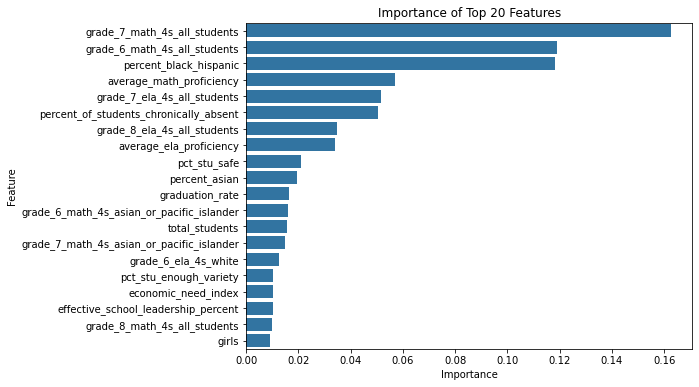

In [138]:
plt.figure(figsize=[8, 6])
top_20_features = feat_importances_df.head(20)
sb.barplot(data=top_20_features, x='importance', y='feature', color=base_color)
plt.title('Importance of Top 20 Features')
plt.ylabel('Feature')
plt.xlabel('Importance');

The three most important features, `grade_7_math_4s_all_students`, `grade_6_math_4s_all_students`, and `percent_black_hispanic` stand out to me. Other than that, it looks like exam success in the sixth to eighth grades, as well as average ELA/math proficiency, are top indicators of whether or not schools will have a high percentage of students taking the SHSAT.

I also want to see how well the model actually fits the data. I will do this first by looking at the actual vs. predicted values.

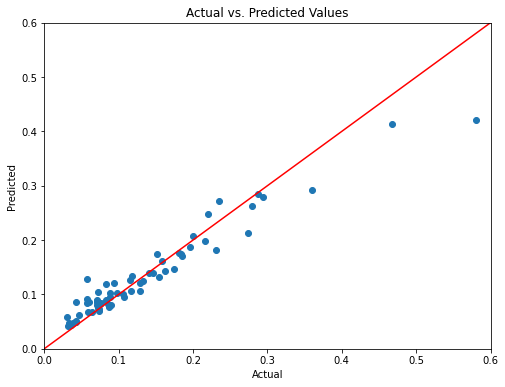

In [139]:
Y_pred = cv_specific.predict(X)
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.scatter(Y, Y_pred)
ax.plot([0, 1], [0, 1], color='r')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, 0.6)
plt.ylim(0, 0.6);

It looks like the predicted values are, for the most part, close to the actual values. The few exceptions are related to outliers in the actual data.

I will also take a look at the distribution of residuals.

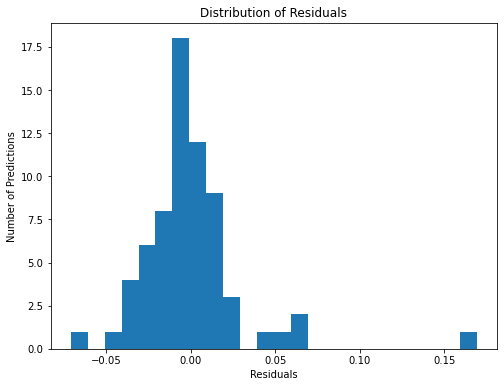

In [140]:
residuals = Y-Y_pred
bin_size = 0.01
bins = np.arange(residuals.min(), residuals.max()+bin_size, bin_size)
plt.figure(figsize=[8, 6])
plt.hist(residuals, bins=bins)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Number of Predictions');

The residuals seem to be approximately normally distributed, except for the aforementioned outliers.

I will also see how the residuals are spread when also looking at the predicted values.

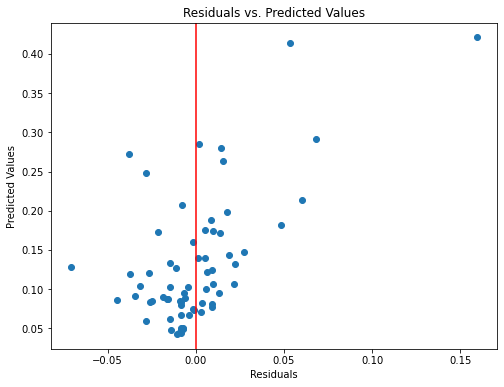

In [141]:
plt.figure(figsize=[8, 6])
plt.scatter(residuals, Y_pred)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Residuals')
plt.ylabel('Predicted Values')
plt.axvline(x=0, color='r');

Based on this visualization, as the predicted values increase, the absolute value of the residuals also appear to increase.

## Conclusion

As mentioned at the beginning, the goal of this project was to determine what variables have the most influential role in predicting what percentage of a school's students will sit for the SHSAT. I determined that exam success in the sixth to eighth grades, average subject proficiency, and the percentage of Black and Hispanic students are strong factors that determine how many students will take the SHSAT at a given school.

One of the biggest challenges was finding adequate data for this process, as PASSNYC only provided SHSAT registration data for District 5. I ended up having to wrangle three datasets and combine them in order to create the target variable that I was looking for. Even then, I had fewer than 100 schools to work with in the final dataset. My original plan was actually to create a predictive model that would allow PASSNYC to predict what percentage of students would sit for the SHSAT at a given school. However, with such little data, it made more sense to use all the data to see feature importances, rather than splitting into even smaller training and test sets.

Based on this challenge, one method to improve the project would be to increase the amount of data that I can use when modeling. There could be several ways to tackle this. Perhaps there is more data on SHSAT registration on the Internet, and I could use web scraping techniques to get this data. I could also think of other ways to construct my target variable, or even change the target variable to measure a difference metric. By doing so, I could end up with more data, which would then allow me to split it up into training and test sets and create a predictive model for PASSNYC going forward.

If finding more data is too difficult, however, I could improve the project by making the model more interpretable. There are a couple of ways to do this. First, I could use the final model to make predictions for the target variable, and then fit a decision tree to the predictions to somewhat mimic the logic of the model. The decision tree could then be plotted in order to visualize the thought process. Another way would be to use local interpretable model-agnostic explanations (LIME). With LIME, I would be able to see what variables are the top contributors to the prediction for a single instance. A downside, though, is that a single instance does not necessarily represent the entire data, so the results may not be applicable to other instances.

Here is a [blog post](https://evanchen13.medium.com/using-data-science-to-increase-diversity-at-new-york-city-high-schools-6611a21ec26c) summarizing the entire process of this project.

## Sources

- [SHSAT](https://en.wikipedia.org/wiki/Specialized_High_Schools_Admissions_Test)
- [School Explorer Data](https://www.kaggle.com/passnyc/data-science-for-good?select=2016+School+Explorer.csv)
- [SHSAT Offers Data](https://www.kaggle.com/infocusp/2017-2018-shsat-admissions-test-offers-by-schools)
- [Department of Education School Directory Data](https://www.kaggle.com/new-york-city/nyc-high-school-directory?select=2017_DOE_High_School_Directory.xlsx)
- [Regex](https://www.debuggex.com/cheatsheet/regex/python)
- [Replace with dictionary](https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict)
- [String index](https://www.programiz.com/python-programming/methods/string/index)
- [Extract hour from time](https://stackoverflow.com/questions/25754405/how-to-extract-hours-and-minutes-from-a-datetime-datetime-object/38439409)
- [Calculate time difference in minutes](https://stackoverflow.com/questions/43305577/python-calculate-the-difference-between-two-datetime-time-objects)
- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [Get feature importance from GridSearchCV](https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv)
- [Visualize regression model performance](https://medium.datadriveninvestor.com/visualizing-scikit-model-performance-fb26ff16f7c6)
- [Interpretable machine learning](https://www.analyticsvidhya.com/blog/2019/08/decoding-black-box-step-by-step-guide-interpretable-machine-learning-models-python/)